Ronaldlee Ejalu

**Kaggle Id: Ronald_Novi**

**Private Ranking: 20**

**Public ranking:  19** 

CSC578 : 901

CSC 578 Time Series Kaggle Class Project



# Project Description
The goal of this project is to apply deep learning to do time series forecasting. In particular, I will create deep learning models to predict future traffic volume at a location in Minnesota between Minneaplois and St Paul. 

The data set I will use is a subset of the [Metro Interstate traffic volume](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) from the UCI respository and the data set description can be found [here](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#). 

The data set is in a csv format with 40+ thousand rows and 9 features:
* holiday: string (None or name of holiday)
* temp: in degrees kelvin
* rain_1h: in mm for the last hour
* snow_1h: in mm for the last hour
* clouds: percent
* weather_main: short descriptive text
* weather_description: longer descriptive text
* date_time: in M/D/Y H:m:s AM/PM format
* traffic_volume: # of cars in the last hour

# Import all packages

In [ ]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.regularizers import l1_l2, l1, l2
# for data Augmentation
from tensorflow.keras import Sequential 
from tensorflow.keras.utils import to_categorical # for processing the categorical labels
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

from keras import layers, models
from tensorflow.keras.utils import get_file, timeseries_dataset_from_array
from keras.layers import LSTM, Dropout, Dense, Bidirectional, Reshape
import pandas as pd
from math import ceil

In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 124 µs (started: 2022-06-29 23:26:56 +00:00)


# Mount the Google Drive

In [ ]:
# mount my Google Drive
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive
time: 29.8 s (started: 2022-06-29 23:26:56 +00:00)


In [ ]:
# Change the working directory to FinalProject
import os
os.chdir('/content/drive/MyDrive/CSC578/FinalProject')

time: 1.24 s (started: 2022-06-29 23:27:26 +00:00)


# Helper functions

In [ ]:
def denormalizeDataFile(prediction_res):
  """
  Function that returns a pandas data frame after denormalizing 
  the data and creates data frame with the predicted traffic_volume
  """
  pred_L = []
  for i in range(prediction_res.shape[0]):
    # helper function that denormalizes the predictions
    res = denormalizePredictions(prediction_res[i][0], train_mean, train_std)
    pred_L.append(res)
  #print('The type of first item in pred_L list is %s'%type(pred_L))

  # we convert the list of panda series into a data frame
  predictions_df = pd.concat(pred_L, axis=1).T

  # reset the index of the predictions data frame
  start = 1
  end = predictions_df.shape[0]
  predictions_df.index = np.arange(start, end + 1)

  # extract the predicted traffic volume by creating a copy of the prediction 
  # data frame with only the traffic column
  predicted_traffic_volume_df = predictions_df[['traffic_volume']].copy()

  # rename the index to id
  predicted_traffic_volume_df.index.names = ['id']

  # rename the traffic column to predictions
  predicted_traffic_volume_df.rename(columns={'traffic_volume':'prediction'}, inplace=True)

  return predicted_traffic_volume_df

time: 9.36 ms (started: 2022-06-29 23:27:27 +00:00)


In [ ]:
def generate_loss_Plot(history_D, EPOCHS=100, titleStr='batch size'):
  """
  Function takes a dictionary of History callbacks and 
  plots line charts for the different hyper parameters
  """
  #print('Training and validation loss line charts for the different mini batch sizes')
  # loop through the history dictionary to access the different items
  for key, value in history_D.items():
    # set the figure
    plt.figure(figsize=(10, 7))
    line_loss = plt.plot(range(0,len(value.history['loss'])), value.history['loss'], '#2c7fb8')
    line_val = plt.plot(range(0,len(value.history['val_loss'])), value.history['val_loss'], '#addd8e')
    global hyperParam 
    hyperParam= titleStr
    if hyperParam == 'batch size':
      var_title = hyperParam

    elif hyperParam == 'learning rate':
      var_title = hyperParam

    elif hyperParam == 'l1 regularization with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l2 regularization with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l1 regularization applied within Dense layer with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l2 regularization applied within Dense layer with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l2 regularization applied within Convolutional and Dense layer with lambda value':
      var_title = hyperParam
    
    elif hyperParam == 'dropout value':
      var_title = hyperParam
    elif hyperParam == 'number_of_recurrent_units':
      var_title = hyperParam
    elif hyperParam == 'dense number units used are':
      var_title = hyperParam
    elif hyperParam == 'size of filter used':
      var_title = hyperParam
    elif hyperParam == 'stride used is':
      var_title = hyperParam
    plt.title('Train vs. Validation loss: when ' + var_title +' = ' + str(key))
    plt.ylabel('loss')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'validation'], bbox_to_anchor=(1, 0.25))
    print('\n')

time: 20.8 ms (started: 2022-06-29 23:27:27 +00:00)


In [ ]:
def denormalizePredictions(predictions, train_mean, train_std):
  """Function that returns the denormalized Predictions"""
  return (predictions * train_std + train_mean)

time: 894 µs (started: 2022-06-29 23:27:27 +00:00)


In [ ]:
def visualizePerformance(lstm_model, performance, val_performance):
  """Returns a barchart visualizing the performance of the different models."""
  x = np.arange(len(performance))
  width = 0.3
  metric_name = 'mean_absolute_error'
  metric_index = lstm_model.metrics_names.index('mean_absolute_error')
  val_mae = [v[metric_index] for v in val_performance.values()]
  test_mae = [v[metric_index] for v in performance.values()]

  plt.ylabel('mean_absolute_error [traffic_volume, normalized]')
  plt.bar(x - 0.17, val_mae, width, label='Validation')
  plt.title('Comparison of models')
  plt.bar(x + 0.17, test_mae, width, label='Test')
  plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
  _ = plt.legend()

time: 6.23 ms (started: 2022-06-29 23:27:27 +00:00)


In [ ]:
def writePredictionsToCsv(predicted_traffic_volume_df_lstm):
  """Function that writes the predictions to a csv file"""
  predicted_traffic_volume_df_lstm.to_csv('predictions.csv', index=True, sep=',')

time: 914 µs (started: 2022-06-29 23:27:28 +00:00)


In [ ]:
def derivePredictions(basic_lstm_model):
  """
  Function that returns the predictions after passing the testing data set 
  of the WindowGeneratotr object as an input parameter to the predict function 
  of the model
  """
  prediction_res = basic_lstm_model.predict(window_5_1_2.test)

  print('The shape of the predictions : %s' %str(prediction_res.shape))
  return prediction_res

time: 1.99 ms (started: 2022-06-29 23:27:28 +00:00)


In [ ]:
def generatePlot_mae(history_D, EPOCHS=100, titleStr='batch size'):
  """
  Function takes a dictionary of History callbacks and 
  plots line charts for the different hyper parameters
  """
  # print('Training and validation loss line charts for the different mini batch sizes')
  # loop through the history dictionary to access the different items
  for key, value in history_D.items():
    # set the figure
    plt.figure(figsize=(10, 7))
    line_mae = plt.plot(range(0,len(value.history['mean_absolute_error'])), value.history['mean_absolute_error'], 'r')
    line_val_mae = plt.plot(range(0,len(value.history['val_mean_absolute_error'])), value.history['val_mean_absolute_error'], '#cdc50a')
    global hyperParam 
    hyperParam= titleStr
    if hyperParam == 'batch size':
      var_title = hyperParam

    elif hyperParam == 'learning rate':
      var_title = hyperParam

    elif hyperParam == 'l1 regularization with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l2 regularization with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l1 regularization applied within Dense layer with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l2 regularization applied within Dense layer with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l2 regularization applied within Convolutional and Dense layer with lambda value':
      var_title = hyperParam
    
    elif hyperParam == 'dropout value':
      var_title = hyperParam
    elif hyperParam == 'number_of_recurrent_units':
      var_title = hyperParam
    elif hyperParam == 'dense number units used are':
      var_title = hyperParam
    elif hyperParam == 'size of filter used':
      var_title = hyperParam
    elif hyperParam == 'stride used is':
      var_title = hyperParam
    plt.title('Train vs. Validation Mean Absolute Error: when ' + var_title +' = ' + str(key))
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'validation'], bbox_to_anchor=(1, 0.25))
    print('\n')

time: 24.4 ms (started: 2022-06-29 23:27:28 +00:00)


In [ ]:
def deriveDataFrame(train_performance_bs,val_performance_bs, performance_bs, columnName, recordTime_L=None):
  """A function that returns pandas data frames for loss, mae and run time execution"""
  column_Name = columnName
  if column_Name == 'batch_size':
    hyperParamName = column_Name
  elif column_Name == 'learningRate':
    hyperParamName = column_Name
  elif column_Name == 'lambda':
    hyperParamName = column_Name
  elif columnName == 'dropout':
    hyperParamName = columnName
  elif columnName == 'number_of_recurrent_units':
    hyperParamName = columnName
  elif columnName == 'number_of_units_used':
    hyperParamName = columnName
  elif columnName == 'size_of_filter':
    hyperParamName = columnName
  elif columnName == 'size_of_stride':
    hyperParamName = columnName

  # create data frame
  train_loss_mae_bs_df = pd.DataFrame.from_dict(data=train_performance_bs).T
  # reset index
  train_loss_mae_bs_df.reset_index(level=0, inplace=True)

  # rename columns
  train_loss_mae_bs_df.rename(columns = {0:'loss', 1:'mae', 'index':'batch_size'}, inplace=True)
  # create data frame and transpose it
  val_loss_mae_bs_df = pd.DataFrame.from_dict(data=val_performance_bs).T
  # reset index
  val_loss_mae_bs_df.reset_index(level=0, inplace=True)
  # rename columns
  val_loss_mae_bs_df.rename(columns = {0:'val_loss', 1:'val_mae', 'index':hyperParamName}, inplace=True)

  # create data frame
  test_loss_mae_bs_df = pd.DataFrame.from_dict(data=performance_bs).T
  # reset index
  test_loss_mae_bs_df.reset_index(level=0, inplace=True)
  # rename columns
  test_loss_mae_bs_df.rename(columns = {0:'test_loss', 1:'test_mae', 'index':hyperParamName}, inplace=True)

  if recordTime_L is not None:
    recordTime_df = pd.DataFrame(recordTime_L, columns = [hyperParamName, 'Time in seconds'])
  return train_loss_mae_bs_df, val_loss_mae_bs_df, test_loss_mae_bs_df, recordTime_df

time: 18.3 ms (started: 2022-06-29 23:27:28 +00:00)


# Download and prepare the Metro Interstate Traffic Volume Data Set.

In [ ]:
# download a file from a URL
origin='http://reed.cs.depaul.edu/peterh/Essays/Metro_Interstate_reduced.csv'


time: 691 µs (started: 2022-06-29 23:27:28 +00:00)


## Get the Data
Use pandas to read the Metro Interstate reduced csv file.

In [ ]:
# load the data into pandas
df_metro = pd.read_csv(origin, parse_dates=['date_time'], na_values=['nan', 'NaN'])

time: 1.05 s (started: 2022-06-29 23:27:28 +00:00)


## Exploratory Data Analysis

In [ ]:
date_time = pd.to_datetime(df_metro.pop('date_time'), format='%d.%m.%Y %H:%M:%S')
date_time

0       2012-10-02 09:00:00
1       2012-10-02 10:00:00
2       2012-10-02 11:00:00
3       2012-10-02 12:00:00
4       2012-10-02 13:00:00
                ...        
40570   2018-09-30 19:00:00
40571   2018-09-30 20:00:00
40572   2018-09-30 21:00:00
40573   2018-09-30 22:00:00
40574   2018-09-30 23:00:00
Name: date_time, Length: 40575, dtype: datetime64[ns]

time: 29.3 ms (started: 2022-06-29 23:27:29 +00:00)


In [ ]:
# look at the first top 5 records
df_metro.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


time: 12.6 ms (started: 2022-06-29 23:27:29 +00:00)


In [ ]:
# look at the last 5 records
df_metro.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
40570,None,283.45,0.0,0.0,75,Clouds,broken clouds,3543
40571,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2781
40572,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159
40573,None,282.09,0.0,0.0,90,Clouds,overcast clouds,1450
40574,None,282.12,0.0,0.0,90,Clouds,overcast clouds,954


time: 10.3 ms (started: 2022-06-29 23:27:29 +00:00)


In [ ]:
df_metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              40575 non-null  object 
 1   temp                 40575 non-null  float64
 2   rain_1h              40575 non-null  float64
 3   snow_1h              40575 non-null  float64
 4   clouds_all           40575 non-null  int64  
 5   weather_main         40575 non-null  object 
 6   weather_description  40575 non-null  object 
 7   traffic_volume       40575 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 2.5+ MB
time: 25.2 ms (started: 2022-06-29 23:27:29 +00:00)


Our data set consists of 40574 records with 9 features where four of them are categorical and the other 5 attributes are numeric.

attitude of the numerical variables

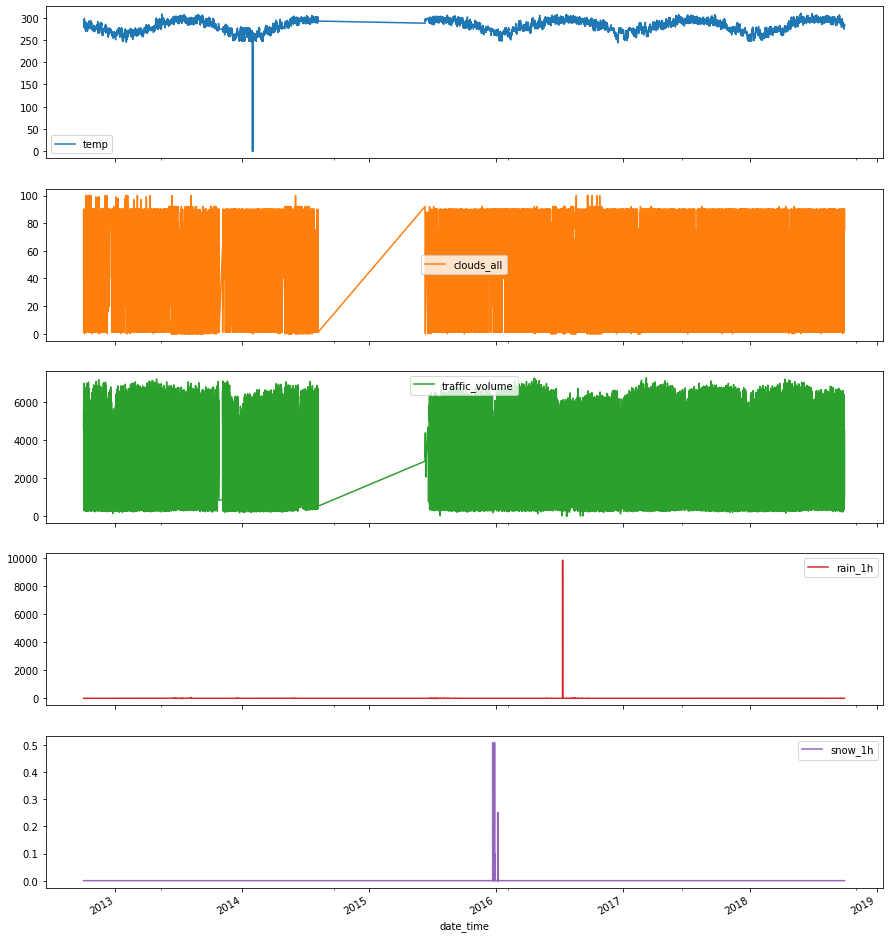

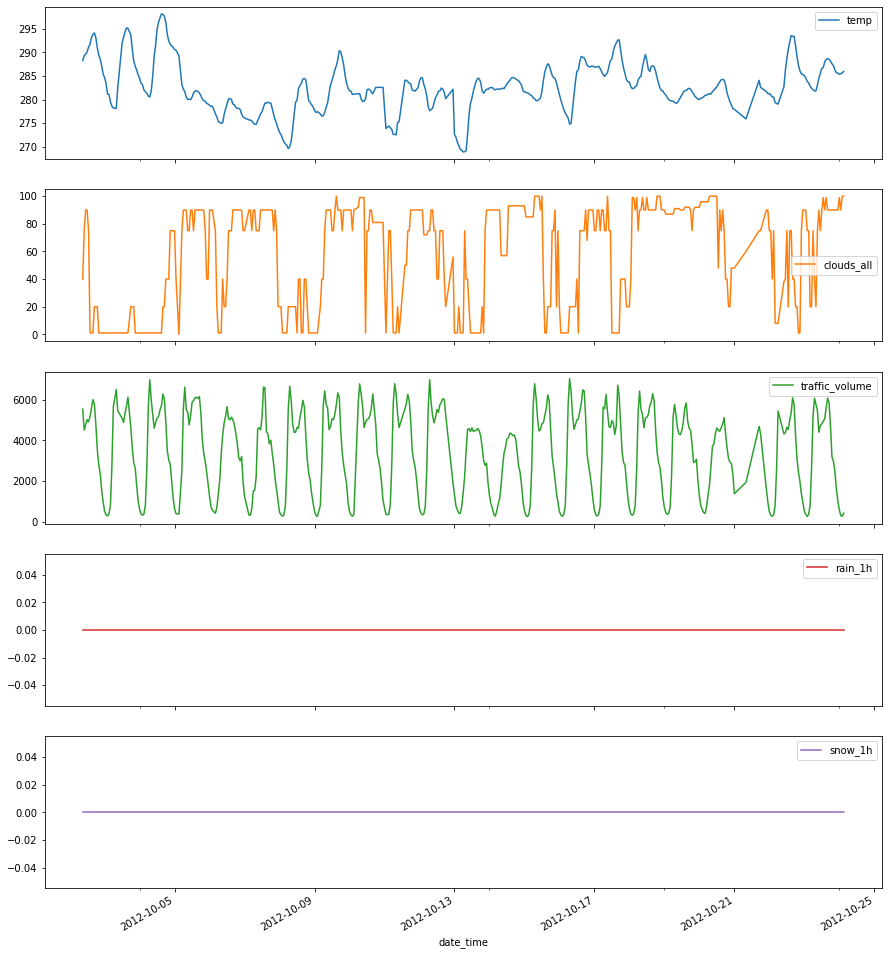

time: 3.73 s (started: 2022-06-29 23:27:29 +00:00)


In [ ]:
# From TF Tutorial
# Selecting the fields of interest
subSelectedColumns = ['temp', 'clouds_all','traffic_volume', 'rain_1h', 'snow_1h']
plotFeatures = df_metro[subSelectedColumns]
plotFeatures.index = date_time
_ = plotFeatures.plot(subplots=True, figsize=(15,18))


# sub select the features of interest and create a sub set data frame with the first 480 records
plotFeatures = df_metro[subSelectedColumns][:480]
# reindex the data frame
plotFeatures.index = date_time[:480]
_ = plotFeatures.plot(subplots=True, figsize=(15,18))

He we see how temperature, clouds_all, traffic volume, rain_1h, and snow for 1 hour involve over time.

derive the descriptive statistics for the multiple columns at the same time and transpose the result

In [ ]:
df_metro.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,40575.0,281.316763,13.816618,0.0,271.84,282.86,292.28,310.07
rain_1h,40575.0,0.318632,48.812640,0.0,0.00,0.00,0.00,9831.30
snow_1h,40575.0,0.000117,0.005676,0.0,0.00,0.00,0.00,0.51
clouds_all,40575.0,44.199162,38.683447,0.0,1.00,40.00,90.00,100.00
traffic_volume,40575.0,3290.650474,1984.772909,0.0,1248.50,3427.00,4952.00,7280.00


time: 40.1 ms (started: 2022-06-29 23:27:32 +00:00)


* The mean temperature is 281.31 in Kelvin.
* The mean traffic volume 

In [ ]:
# unique values of each numerical attribute value
dfColumns=[]
for col in  df_metro.columns:
  dfColumns.append([col, df_metro[col].nunique(), df_metro[col].drop_duplicates().values])
pd.DataFrame(dfColumns, columns=['Features', 'Unique Number', 'Values'])

,Features,Unique Number,Values
0,holiday,12,"[None, Columbus Day, Veterans Day, Thanksgivin..."
1,temp,5841,"[288.28, 289.36, 289.58, 290.13, 291.14, 291.7..."
2,rain_1h,372,"[0.0, 0.25, 0.57, 0.38, 0.3, 0.29, 0.44, 0.36,..."
3,snow_1h,12,"[0.0, 0.51, 0.32, 0.06, 0.05, 0.21, 0.25, 0.44..."
4,clouds_all,60,"[40, 75, 90, 1, 20, 0, 100, 92, 99, 81, 50, 72..."
5,weather_main,11,"[Clouds, Clear, Rain, Drizzle, Mist, Fog, Thun..."
6,weather_description,35,"[scattered clouds, broken clouds, overcast clo..."
7,traffic_volume,6704,"[5545, 4516, 4767, 5026, 4918, 5181, 5584, 601..."


time: 27.9 ms (started: 2022-06-29 23:27:33 +00:00)


In [ ]:
# let's determine if there are any missing values
df_metro.isnull().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
traffic_volume         0
dtype: int64

time: 11.3 ms (started: 2022-06-29 23:27:33 +00:00)


We see the unique values of each and every column.

In [ ]:
# value counts for the holiday column values
df_metro['holiday'].value_counts()

None                         40522
Columbus Day                     5
Veterans Day                     5
Thanksgiving Day                 5
Christmas Day                    5
New Years Day                    5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Labor Day                        5
Martin Luther King Jr Day        3
Name: holiday, dtype: int64

time: 7.74 ms (started: 2022-06-29 23:27:33 +00:00)


We see None doesn't belong to any of the holidays. 

In [ ]:
# let's add datime back to the field
df_metro['date_time'] = date_time

time: 1.79 ms (started: 2022-06-29 23:27:33 +00:00)


In [ ]:
# To get summary statistics on object columns
# here i am including only non numeric data types
df_metro.describe(include=object)

,holiday,weather_main,weather_description
count,40575,40575,40575
unique,12,11,35
top,None,Clouds,sky is clear
freq,40522,15123,11642


time: 26.7 ms (started: 2022-06-29 23:27:33 +00:00)


Here the unique, top and frequencies of each of the categorical columns.

In [ ]:
# summarizing the weather description column
df_metro['weather_description'].value_counts()

sky is clear                           11642
overcast clouds                         5072
broken clouds                           4650
scattered clouds                        3451
mist                                    3069
light rain                              2831
few clouds                              1950
Sky is Clear                            1724
light snow                              1588
moderate rain                           1379
haze                                     766
heavy snow                               500
heavy intensity rain                     408
light intensity drizzle                  360
proximity thunderstorm                   339
fog                                      201
snow                                     192
drizzle                                  138
proximity shower rain                    120
thunderstorm                              59
thunderstorm with light rain              23
very heavy rain                           18
heavy inte

time: 7.11 ms (started: 2022-06-29 23:27:33 +00:00)


Here we observe how many times each word occurs in the weather description column.

We notice alot of descriptions therefore, we look at the top and group the rest into one bucket:

In [ ]:
top_n = df_metro['weather_description'].value_counts().index[:10]
(
    df_metro.assign(
    weather_description = df_metro['weather_description'].where(df_metro['weather_description'].isin(top_n), "Other Weather descriptions"
                                                        )
    ).weather_description.value_counts()
)

sky is clear                  11642
overcast clouds                5072
broken clouds                  4650
scattered clouds               3451
Other Weather descriptions     3219
mist                           3069
light rain                     2831
few clouds                     1950
Sky is Clear                   1724
light snow                     1588
moderate rain                  1379
Name: weather_description, dtype: int64

time: 17 ms (started: 2022-06-29 23:27:33 +00:00)


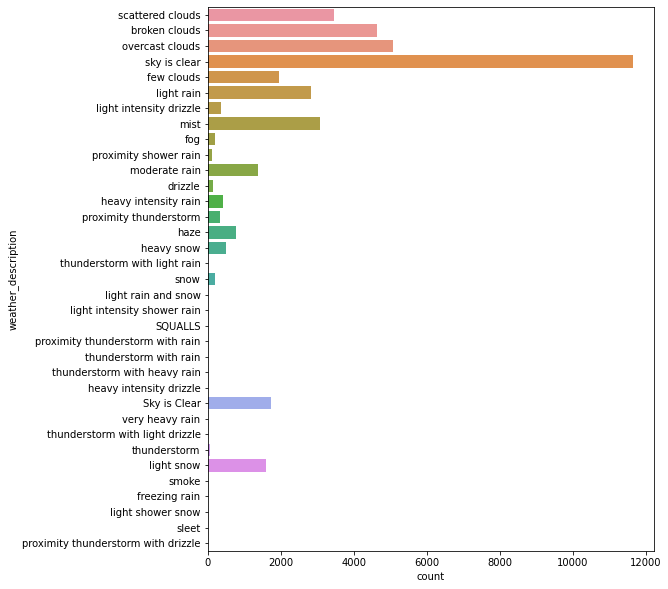

time: 377 ms (started: 2022-06-29 23:27:33 +00:00)


In [ ]:
fig, ax = plt.subplots(figsize=(8, 10))
top_n = df_metro['weather_description'].value_counts().index[:10]
sns.countplot(
    y=df_metro['weather_description'],
    data = (
    df_metro.assign(
    weather_description = df_metro['weather_description'].where(df_metro['weather_description'].isin(top_n), "Other Weather descriptions"
                                                        )
    ).weather_description.value_counts()
)
)
plt.show()

From the countplot above we see that the weather description, **sky is clear** has the largest number of occurences in the column.

In [ ]:
df_metro['weather_main'].value_counts()

Clouds          15123
Clear           13366
Rain             4769
Mist             3069
Snow             2297
Haze              766
Drizzle           515
Thunderstorm      453
Fog               201
Smoke              15
Squall              1
Name: weather_main, dtype: int64

time: 6.94 ms (started: 2022-06-29 23:27:33 +00:00)


Here we see the distribution of these descriptions in our data set field, **weather_main**.

A Histogram showing the distribution of traffic volume:

In [ ]:
# calculation of bin width
q3 = 4952.00
q1 = 1248.50
n = 40575
max = 7280.00
min = 0.0
bin_width = 2 * (q3 - q1)/ (n ** (1/3))

bins = ceil((max - min)/bin_width)

time: 2.29 ms (started: 2022-06-29 23:27:33 +00:00)


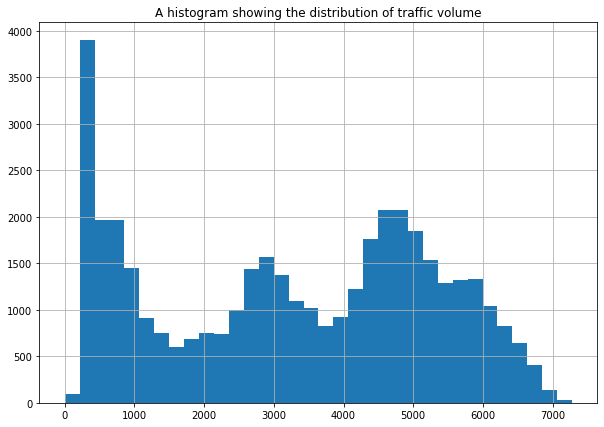

time: 208 ms (started: 2022-06-29 23:27:33 +00:00)


In [ ]:
# using pandas to plot a histogram 
fig, ax = plt.subplots(figsize=(10, 7))
df_metro['traffic_volume'].hist(ax=ax, bins=bins)
plt.title('A histogram showing the distribution of traffic volume')
plt.show()

This shows that traffic volume is not normally distributed.

We could also derive a **probability plot** to determine if the data is normal:

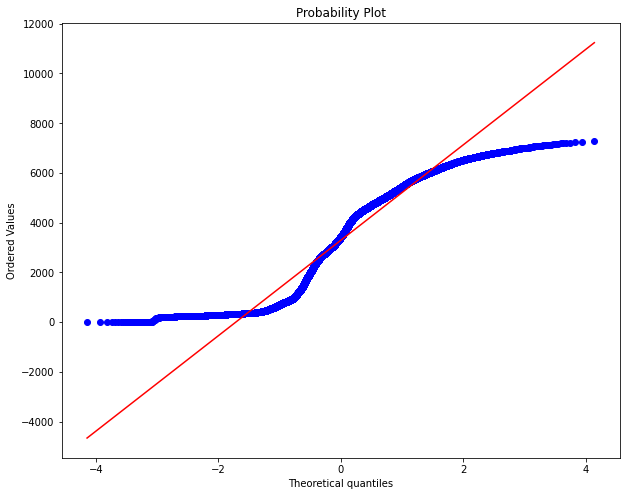

time: 250 ms (started: 2022-06-29 23:27:33 +00:00)


In [ ]:
from scipy import stats
fig, ax = plt.subplots(figsize=(10, 8))
stats.probplot(df_metro['traffic_volume'], plot=ax)
plt.show()

We see that the values are off the trackline.

In [ ]:
# value counts for weather main.
df_metro['weather_main'].value_counts()

Clouds          15123
Clear           13366
Rain             4769
Mist             3069
Snow             2297
Haze              766
Drizzle           515
Thunderstorm      453
Fog               201
Smoke              15
Squall              1
Name: weather_main, dtype: int64

time: 7.35 ms (started: 2022-06-29 23:27:34 +00:00)


Let's compare the traffic volume across the values of the **'weather main'** column.

In [ ]:
# createa mask for the different kinds of weather main
weather_mask = df_metro['weather_main'].isin(['Rain', 'Snow', 'Fog', 'Smoke', 'Mist', 'Clouds'])

time: 3.43 ms (started: 2022-06-29 23:27:34 +00:00)


In [ ]:
# we use a groupby method to look at the mean and standrd deviation for traffic volume for each of the group of weather
df_metro[weather_mask].groupby('weather_main').traffic_volume.agg(['mean', 'std'])

,mean,std
weather_main,,
Clouds,3616.988230,1906.836777
Fog,2724.442786,2308.840663
Mist,2854.214076,2158.628973
Rain,3355.270287,1978.814253
Smoke,2559.666667,1786.344658
Snow,3001.861123,1898.664631


time: 14.4 ms (started: 2022-06-29 23:27:34 +00:00)


let's visualize the traffic_volume for each weather main category:

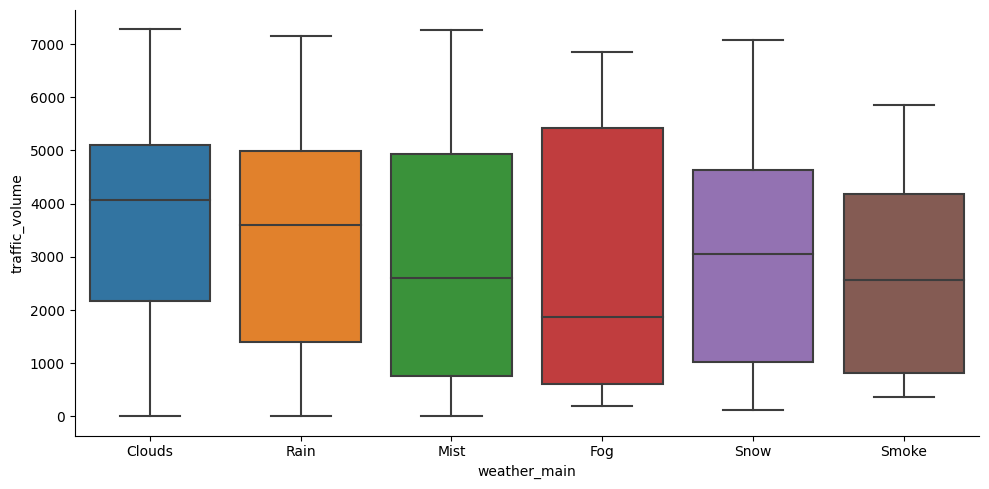

time: 517 ms (started: 2022-06-29 23:27:34 +00:00)


In [ ]:
weather_main_graph = sns.catplot(
    x='weather_main', y='traffic_volume', data=df_metro[weather_mask], kind='box', height = 5, aspect=2.0
)
weather_main_graph.fig.set_dpi(100)

Here see that on Fog and Mist days, there is less traffic.On Cloudy, Rainy, and Snowy days, traffic volume is high.

deriving time series for traffic volume:

In [ ]:
# lets create a copy of the data frame
df_metro_date_time_traffic_volume = df_metro.copy()

time: 3.76 ms (started: 2022-06-29 23:27:34 +00:00)


In [ ]:
df_metro_date_time_traffic_volume['trafficDate'] = pd.to_datetime(df_metro_date_time_traffic_volume['date_time']).dt.date
df_metro_date_time_traffic_volume.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,date_time,trafficDate
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,2012-10-02 09:00:00,2012-10-02
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,2012-10-02 10:00:00,2012-10-02
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,2012-10-02 11:00:00,2012-10-02
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,2012-10-02 12:00:00,2012-10-02
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,2012-10-02 13:00:00,2012-10-02


time: 35.1 ms (started: 2022-06-29 23:27:34 +00:00)


In [ ]:
# let's drop the uncessary columns
df_metro_date_time_traffic_volume.drop(columns=['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description', 'date_time'], inplace=True)

time: 6.59 ms (started: 2022-06-29 23:27:34 +00:00)


In [ ]:
# we use a groupby method to look at the mean  for traffic volume for each of the days
traffic_volumne_mean_df = df_metro_date_time_traffic_volume.groupby('trafficDate').traffic_volume.agg(['mean'])

time: 8.2 ms (started: 2022-06-29 23:27:34 +00:00)


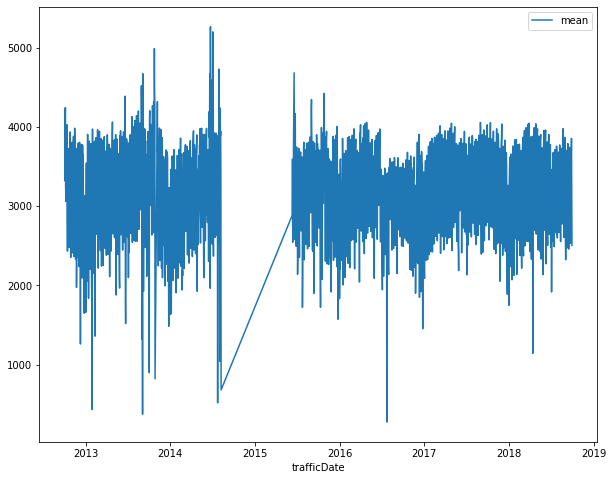

time: 212 ms (started: 2022-06-29 23:27:34 +00:00)


In [ ]:
_ = traffic_volumne_mean_df.plot(subplots=True, figsize=(10, 8))


We see the behavior of traffic volume over the years.

Drop all the Categorical variables and create a new data frame

In [ ]:
# Create numeric dataset with only numerical variables
df_trafficWeather = df_metro.drop(columns=['holiday',   'weather_main', 'weather_description', 'date_time'])

# reset the index of the data frame
# df_trafficWeather.set_index(['date_time'])
df_trafficWeather.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,288.28,0.0,0.0,40,5545
1,289.36,0.0,0.0,75,4516
2,289.58,0.0,0.0,90,4767
3,290.13,0.0,0.0,90,5026
4,291.14,0.0,0.0,75,4918


time: 12.4 ms (started: 2022-06-29 23:27:34 +00:00)


In [ ]:
# look at the meta data of the dataframe
df_trafficWeather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            40575 non-null  float64
 1   rain_1h         40575 non-null  float64
 2   snow_1h         40575 non-null  float64
 3   clouds_all      40575 non-null  int64  
 4   traffic_volume  40575 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 1.5 MB
time: 10.9 ms (started: 2022-06-29 23:27:34 +00:00)


In [ ]:
# shape of the data frame
df_trafficWeather.shape

(40575, 5)

time: 5.8 ms (started: 2022-06-29 23:27:34 +00:00)


In [ ]:
# let's determine if there are any missing values
df_trafficWeather.isnull().sum()

temp              0
rain_1h           0
snow_1h           0
clouds_all        0
traffic_volume    0
dtype: int64

time: 5.09 ms (started: 2022-06-29 23:27:35 +00:00)


So, there are no missing values in our data frame.

## Time transformation
Lets convert the data time into seconds

In [ ]:
# From TF Tutorial
timestamp_s = date_time.map(pd.Timestamp.timestamp)

time: 316 ms (started: 2022-06-29 23:27:35 +00:00)


we create signals by using sine and consine transform transform, which we shall use to deal with periodicity,:

In [ ]:
# From TF Tutorial
day = 24 * 60 * 60
year = (365.2425) * day

df_trafficWeather['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_trafficWeather['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_trafficWeather['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_trafficWeather['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

time: 14 ms (started: 2022-06-29 23:27:35 +00:00)


In [ ]:
df_trafficWeather.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,40575.0,281.316763,13.816618,0.0,271.840000,2.828600e+02,292.280000,310.07
rain_1h,40575.0,0.318632,48.812640,0.0,0.000000,0.000000e+00,0.000000,9831.30
snow_1h,40575.0,0.000117,0.005676,0.0,0.000000,0.000000e+00,0.000000,0.51
clouds_all,40575.0,44.199162,38.683447,0.0,1.000000,4.000000e+01,90.000000,100.00
traffic_volume,40575.0,3290.650474,1984.772909,0.0,1248.500000,3.427000e+03,4952.000000,7280.00
Day sin,40575.0,-0.001680,0.705984,-1.0,-0.707107,-3.043547e-13,0.707107,1.00
Day cos,40575.0,0.005320,0.708223,-1.0,-0.707107,5.802386e-13,0.707107,1.00
Year sin,40575.0,0.008868,0.697617,-1.0,-0.666517,-1.114574e-02,0.704264,1.00
Year cos,40575.0,-0.041783,0.715214,-1.0,-0.761371,-9.070939e-02,0.688574,1.00


time: 44.5 ms (started: 2022-06-29 23:27:35 +00:00)


Plotting the signals

Text(0.5, 1.0, 'Time of day signal')

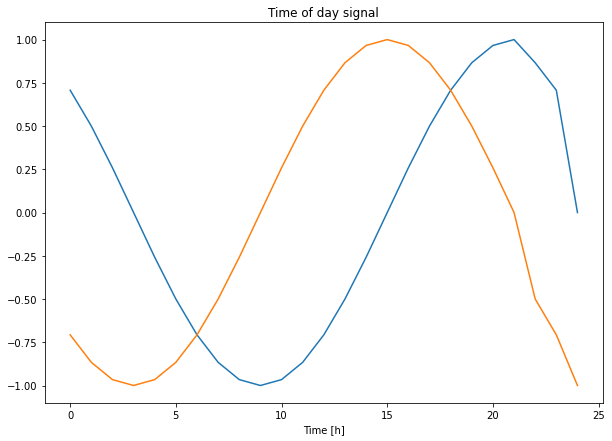

time: 197 ms (started: 2022-06-29 23:27:35 +00:00)


In [ ]:
# From TF Tutorial
plt.figure(figsize=(10, 7))
plt.plot(np.array(df_trafficWeather['Day sin'][:25]))
plt.plot(np.array(df_trafficWeather['Day cos'][:25]))
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the likely main frequency attributes.

## Splitting the data set

create a dictionary of column indicies:

In [ ]:
# From TF Tutorial
# create a dictionary of column indicies:
column_indices = {name: i for i, name in enumerate(df_trafficWeather.columns)}

time: 1.55 ms (started: 2022-06-29 23:27:35 +00:00)


split the data set

In [ ]:
# From TF Tutorail
# first take off the 5000 from 
test_df = df_trafficWeather.iloc[-5000:]

n = (df_trafficWeather.shape[0] - 5000)

train_df = df_trafficWeather[0:int(n*0.7)]

val_df = df_trafficWeather[int(n*0.7):n]


num_features = df_trafficWeather.shape[1]

print('Training   set : %d' %train_df.shape[0])
print('validation set : %d' %val_df.shape[0])
print('Testing    set : %d' %test_df.shape[0])
print('-'*23)
print('Total          : %d' %(train_df.shape[0] + val_df.shape[0] + test_df.shape[0]))

# train_df.shape, val_df.shape, test_df.shape

Training   set : 24902
validation set : 10673
Testing    set : 5000
-----------------------
Total          : 40575
time: 7.43 ms (started: 2022-06-29 23:27:35 +00:00)


## Normalize the data sets.


In [ ]:
# From TF Tutorial
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

time: 22.4 ms (started: 2022-06-29 23:27:35 +00:00)


let's look at the distribution of the features.

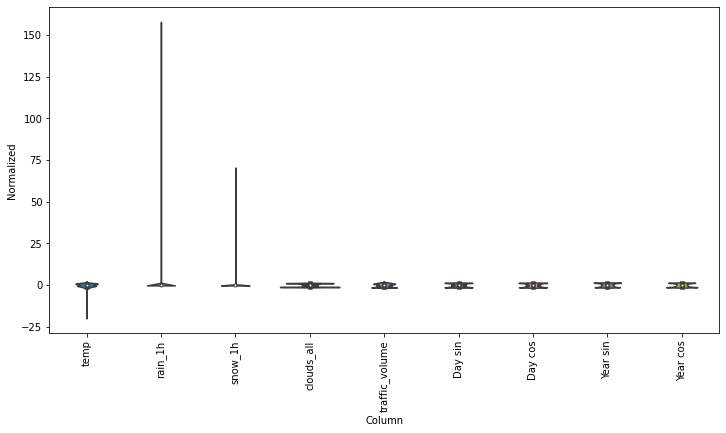

time: 1.36 s (started: 2022-06-29 23:27:35 +00:00)


In [ ]:
df_trafficWeather_std  = (df_trafficWeather - train_mean) / train_std
df_trafficWeather_std = df_trafficWeather_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_trafficWeather_std)
_ = ax.set_xticklabels(df_trafficWeather.keys(), rotation=90)

Some features like rain_1h and snow_1h have long tails, which is an indication of having outliers within our data set.

## Data Windowing

### 1. Indexes and offsets From TF Tutorial




let's start by creating the WindowGenerator class

In [ ]:
# From TF Tutorial
class WindowGenerator():
  """
  The main features of the input windows are:
  The width (number of time steps) of the input and label windows.
  The time offset between them.
  Which features are used as inputs, labels, or both.
  """
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    """
    This method includes all the necessary logic 
    for the input and label indicies
    """
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    #print('input_width : %d' %self.input_width)
    self.label_width = label_width
    #print('label_width : %d' %self.label_width)
    self.shift = shift
    #print('shift: %d' %self.shift)

    self.total_window_size = input_width + shift
    #print('total_window_size = input_width + shift : %d' %self.total_window_size)

    self.input_slice = slice(0, input_width) # slice a sequence
    #print('input_slice : %s ' %str(self.input_slice))
    # retrieve five items from the numpy array
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    #print('input_indices : %s' %str(self.input_indices))

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

time: 21.6 ms (started: 2022-06-29 23:27:37 +00:00)


### 2. Split From TF Tutorial

let's define a split_window function that converts a list of consecutive inputs into a window of inputs and a window of labels.

In [ ]:
# From TF Tutorial
def split_window(self, features):
  """
  Function that returns a window of inputs and a window of labels 
  that result from the conversion of a list consecutive inputs 
  """
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  # From TF Tutorial
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  #print('inputs: %s' %str(inputs))
  #print('labels: %s' %str(labels))
  return inputs, labels

WindowGenerator.split_window = split_window

time: 7.93 ms (started: 2022-06-29 23:27:37 +00:00)


### 3. Using the plot method to create the right windows. 
The inputs, labels and predictions based on time are aligned by this plot.

Let's start by creating the function.

In [ ]:
# From TF Tutorial
def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
  inputs, labels = self.example
  #print('shape of inputs: %s' %str(inputs.Shape))
  #print('shape of labels: %s' %str(labels.Shape))
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      #print('The size of the predictions: %s' %str(predictions.Shape))
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

time: 17.7 ms (started: 2022-06-29 23:27:37 +00:00)


### 4. Convert a time series DataFrame into pairs of input_window and label_window, (input_window, label_window).

start by creating a function:

In [ ]:
# From TF Tutorial
def make_dataset(self, data):
  """
  Return a dataset of (input_window, label_window) pairs
  """
  data = np.array(data, dtype=np.float32)
  ds = timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False, # turn off the default shuffling
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

time: 3.51 ms (started: 2022-06-29 23:27:37 +00:00)


adding properties to access training, validation and test data set through the make_dataset defined method:

In [ ]:
# From TF Tutorial
@property
def train(self):
  """access the training data set through the make_dataset method"""
  shuffle=True                          # shuffle the training set
  return self.make_dataset(self.train_df)

@property
def val(self):
  """access the validation data set through the make_dataset method"""
  shuffle = False
  return self.make_dataset(self.val_df)

@property
def test(self):
  """access the test data set through the make_dataset method"""
  shuffle=False
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

time: 11.8 ms (started: 2022-06-29 23:27:37 +00:00)


### Performance BaseLine model
This will act as a baseline model to be compared with later more complicated models.

Our goal is to predict traffic volume into the future, given the current value of all features. 

First, we create a Baseline class:

In [ ]:
# From TF Tutorial
class Baseline(tf.keras.Model):
  """fowards the input to the output"""
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

time: 3.63 ms (started: 2022-06-29 23:27:37 +00:00)


In [ ]:
# create a WindowGenerator object
window_5_1_2 = WindowGenerator(input_width=5, label_width=1, shift=2, label_columns=['traffic_volume'])
window_5_1_2

Total window size: 7
Input indices: [0 1 2 3 4]
Label indices: [6]
Label column name(s): ['traffic_volume']

time: 5.23 ms (started: 2022-06-29 23:27:37 +00:00)


Instantiate and validate the model:

In [ ]:
# From TF Tutorial
baseline = Baseline(label_index=column_indices['traffic_volume'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(window_5_1_2.val)
performance['Baseline'] = baseline.evaluate(window_5_1_2.test, verbose=0)

334/334 [==============================] - 1s 2ms/step - loss: 1.3292 - mean_absolute_error: 0.9021
time: 6.24 s (started: 2022-06-29 23:27:37 +00:00)


let's create a WindowGenerator object, which derives windows 24 hours of consecutive inputs and labels at a time.

### Linear model
Without any activations, let's insert a linear transformation in between the input and output. 

In [ ]:
# Without inserting any activations,
# this layer transforms the last axis of data from (batch, time, inputs) to (batch, time, units)
# From TF Tutorial
linear_model = Sequential([
                     layers.Dense(units=1)
])

time: 10.3 ms (started: 2022-06-29 23:27:43 +00:00)


helper function that compiles and fits the training data to the network model.

In [ ]:
#EPOCHS = 20
EPOCHS = 50

def compileAndFit(model, window, patience=2):
  """
  Function that returns the model's history after compiling 
  and fitting the training data to the model
  """
  early_stopping = EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min', verbose=1)
  # compile the model
  model.compile(loss=MeanSquaredError(),
                optimizer=Adam(),
                metrics=[MeanAbsoluteError()])
  # fit the data with with the network model
  history = model.fit(window.train, epochs=EPOCHS,batch_size=4,
                      validation_data=window.val,
                      callbacks=[early_stopping]
                      )
  return history

time: 3.8 ms (started: 2022-06-29 23:27:43 +00:00)


### Recurrent neural network
A type of neural network well-suited for time-series data.

Create an LSTM model:

In [ ]:
lstm_model = Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    # return_sequence=True means the model can be trained on 24 hours of data at a time.
    layers.LSTM(64, return_sequences=False, activation='relu'),
    
    # 128
    #layers.Dense(32, activation='relu'),
    #layers.Dropout(0.4),
    #layers.LSTM(32, return_sequences=False),
    #layers.Dropout(0.4),
    # 128
    layers.Dense(128, activation='relu'),
    layers.Dense(units=1)
    #layers.Reshape([1, -1])

])

time: 16.5 ms (started: 2022-06-29 23:27:43 +00:00)


In [ ]:
# create a WindowGenerator object
window_5_1_2 = WindowGenerator(input_width=5, label_width=1, shift=2, label_columns=['traffic_volume'])
window_5_1_2

Total window size: 7
Input indices: [0 1 2 3 4]
Label indices: [6]
Label column name(s): ['traffic_volume']

time: 4.41 ms (started: 2022-06-29 23:27:43 +00:00)


In [ ]:
print('Input shape:', window_5_1_2.example[0].shape)
print('Output shape:', lstm_model(window_5_1_2.example[0]).shape)

Input shape: (32, 5, 9)
Output shape: (32, 1)
time: 2.5 s (started: 2022-06-29 23:27:43 +00:00)


Compile, train the LSTM model on the train and evaluate it:

In [ ]:
history = compileAndFit(lstm_model, window_5_1_2)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(window_5_1_2.val)
performance['LSTM'] = lstm_model.evaluate(window_5_1_2.test, verbose=0)

334/334 [==============================] - 1s 3ms/step - loss: 0.0592 - mean_absolute_error: 0.1747
time: 2min 56s (started: 2022-06-29 23:27:45 +00:00)


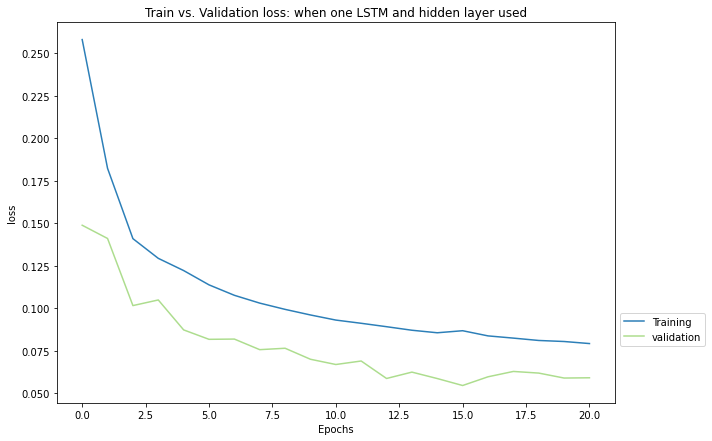

time: 220 ms (started: 2022-06-29 23:30:42 +00:00)


In [ ]:
plt.figure(figsize=(10, 7))
line_loss = plt.plot(range(0,len(history.history['loss'])), history.history['loss'], '#2c7fb8')
line_val = plt.plot(range(0,len(history.history['val_loss'])), history.history['val_loss'], '#addd8e')

plt.title('Train vs. Validation loss: when one LSTM and hidden layer used')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'validation'], bbox_to_anchor=(1, 0.25))
print('\n')

Training loss is higher than validation loss implying that the model is overfitting the training data.

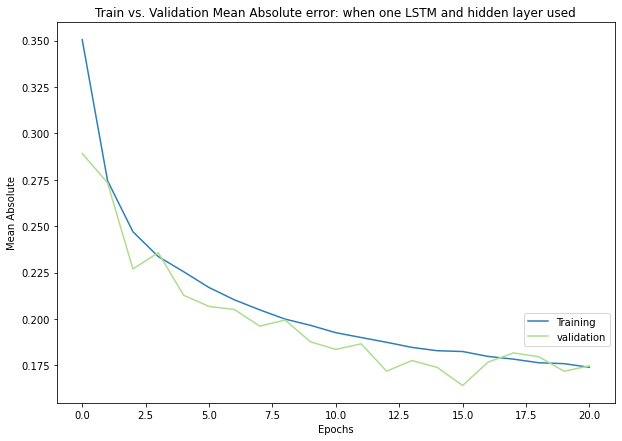

time: 204 ms (started: 2022-06-29 23:30:43 +00:00)


In [ ]:
plt.figure(figsize=(10, 7))
line_loss = plt.plot(range(0,len(history.history['mean_absolute_error'])), history.history['mean_absolute_error'], '#2c7fb8')
line_val = plt.plot(range(0,len(history.history['val_mean_absolute_error'])), history.history['val_mean_absolute_error'], '#addd8e')

plt.title('Train vs. Validation Mean Absolute error: when one LSTM and hidden layer used')
plt.ylabel('Mean Absolute')
plt.xlabel('Epochs')
plt.legend(['Training', 'validation'], bbox_to_anchor=(1, 0.25))
print('\n')

Validation absolute error seems to be unstable.

#### derive the predictions

In [ ]:
# a helper function that retruns the predictions after passing the testing 
# data set of the WindowGeneratotr object as input parameter 
# to the predict function of the model, basic_lstm_model
prediction_res_lstm = derivePredictions(lstm_model)

The shape of the predictions : (4994, 1)
time: 563 ms (started: 2022-06-29 23:30:43 +00:00)


Denormalize the predictions

In [ ]:
# using a helper function to denormalize the predictions and return data frame
predicted_traffic_volume_df_lstm_one = denormalizeDataFile(prediction_res_lstm)

time: 1.42 s (started: 2022-06-29 23:30:43 +00:00)


In [ ]:
# the top 5 predictions
predicted_traffic_volume_df_lstm_one.head()

,prediction
id,
1,2214.687069
2,5464.141247
3,6391.053039
4,5565.452823
5,4666.958259


time: 5.49 ms (started: 2022-06-29 23:30:45 +00:00)


#### Write the predictions to a file.

In [ ]:
# a helper function that recieves a data frame as an argument 
# and writes the contents of the data frame to a csv file
writePredictionsToCsv(predicted_traffic_volume_df_lstm_one)

time: 386 ms (started: 2022-06-29 23:30:45 +00:00)


#### Recurrent dropout

Since the model is overfitting, lets try to add dropout to randomly ignore layer outputs

In [ ]:
# create the model
lstm_model_dropout = Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    # return_sequence=True means the model can be trained on 24 hours of data at a time.
    layers.LSTM(64, return_sequences=False, activation='relu'),
    
    # 128
    #layers.Dense(32, activation='relu'),
    #layers.Dropout(0.4),
    #layers.LSTM(32, return_sequences=False),
    #layers.Dropout(0.4),
    # 128
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dense(units=1)
    #layers.Reshape([1, -1])

])

time: 13.3 ms (started: 2022-06-29 23:30:45 +00:00)


In [ ]:
print('Input shape:', window_5_1_2.example[0].shape)
print('Output shape:', lstm_model_dropout(window_5_1_2.example[0]).shape)

Input shape: (32, 5, 9)
Output shape: (32, 1)
time: 89.5 ms (started: 2022-06-29 23:30:45 +00:00)


In [ ]:
history = compileAndFit(lstm_model_dropout, window_5_1_2)

IPython.display.clear_output()
val_performance['LSTM_dropout'] = lstm_model_dropout.evaluate(window_5_1_2.val)
performance['LSTM_dropout'] = lstm_model_dropout.evaluate(window_5_1_2.test, verbose=0)

334/334 [==============================] - 1s 3ms/step - loss: 0.0577 - mean_absolute_error: 0.1844
time: 4min 37s (started: 2022-06-29 23:30:45 +00:00)


### Basic_lstm_model

In [ ]:
# build the basic lstm model
basic_lstm_model = Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    # return_sequence=True means the model can be trained on 24 hours of data at a time.
    layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    layers.LSTM(32, return_sequences=False),
    layers.Dense(units=1),
    layers.Reshape([1, -1])
])

time: 11.9 ms (started: 2022-06-29 23:35:23 +00:00)


Let's create a WindowGenerator object, window_5_1_2

In [ ]:
# create a WindowGenerator object
window_5_1_2 = WindowGenerator(input_width=5, label_width=1, shift=2, label_columns=['traffic_volume'])
window_5_1_2

Total window size: 7
Input indices: [0 1 2 3 4]
Label indices: [6]
Label column name(s): ['traffic_volume']

time: 5.28 ms (started: 2022-06-29 23:35:23 +00:00)


In [ ]:
for example_inputs, example_labels in window_5_1_2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 5, 9)
Labels shape (batch, time, features): (32, 1, 1)
time: 78.4 ms (started: 2022-06-29 23:35:23 +00:00)


Compile, train the LSTM model on the train and evaluate it:

In [ ]:
history = compileAndFit(basic_lstm_model, window_5_1_2)

IPython.display.clear_output()
val_performance['basic_lstm_model'] = basic_lstm_model.evaluate(window_5_1_2.val)
performance['basic_lstm_model'] = basic_lstm_model.evaluate(window_5_1_2.test, verbose=0)

334/334 [==============================] - 1s 3ms/step - loss: 0.0509 - mean_absolute_error: 0.1591
time: 3min 21s (started: 2022-06-29 23:35:23 +00:00)


In [ ]:
# model summary
basic_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 32)             5376      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
 reshape (Reshape)           (None, 1, 1)              0         
                                                                 
Total params: 13,729
Trainable params: 13,729
Non-trainable params: 0
_________________________________________________________________
time: 23.1 ms (started: 2022-06-29 23:38:44 +00:00)


In [ ]:
print('Input shape:', window_5_1_2.example[0].shape)
print('Output shape:', basic_lstm_model(window_5_1_2.example[0]).shape)

Input shape: (32, 5, 9)
Output shape: (32, 1, 1)
time: 89.4 ms (started: 2022-06-29 23:38:44 +00:00)


#### derive the predictions

In [ ]:
# a helper function that retruns the predictions after passing the testing 
# data set of the WindowGeneratotr object as input parameter 
# to the predict function of the model, basic_lstm_model
prediction_res = derivePredictions(basic_lstm_model)

The shape of the predictions : (4994, 1, 1)
time: 1.06 s (started: 2022-06-29 23:38:44 +00:00)


In [ ]:
#qa_L = []
#for i in range(len(prediction_res)):
#  res = prediction_res[i] * train_std + train_mean
#  qa_L.append(res)
  

time: 853 µs (started: 2022-06-29 23:38:45 +00:00)


#### Denormalize the predictions
Since we have train_std and train_mean, we use the helper function, denormalizePredictions, to denormalize the predictions.

In [ ]:
# using a helper function to denormalize the predictions and return data frame
predicted_traffic_volume_df_lstm = denormalizeDataFile(prediction_res)

time: 1.31 s (started: 2022-06-29 23:38:46 +00:00)


In [ ]:
# the top 5 predictions
predicted_traffic_volume_df_lstm.head()

,prediction
id,
1,3420.611200
2,5740.676965
3,6217.683198
4,4663.232465
5,4335.592620


time: 6.04 ms (started: 2022-06-29 23:38:47 +00:00)


In [ ]:
# th last five predictions
predicted_traffic_volume_df_lstm.tail()

,prediction
id,
4990,3607.636882
4991,3135.918652
4992,2894.340527
4993,2508.414433
4994,1636.634753


time: 4.9 ms (started: 2022-06-29 23:38:47 +00:00)


#### Write the predictions a csv file:

In [ ]:
# a helper function that recieves a data frame as an argument 
# and writes the contents of the data frame to a csv file
writePredictionsToCsv(predicted_traffic_volume_df_lstm)

time: 17.7 ms (started: 2022-06-29 23:38:47 +00:00)


#### Visualizing the performance of the basic_lstm_model:

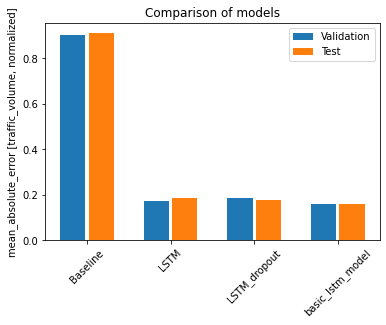

time: 153 ms (started: 2022-06-29 23:38:47 +00:00)


In [ ]:
visualizePerformance(basic_lstm_model, performance, val_performance)

We see the basic_lstm_model performs pretty much the same way as the Baseline model. 

#### Grid Search CV

In [ ]:
"""
def deriveModel():
  basic_lstm_model = Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    # return_sequence=True means the model can be trained on 24 hours of data at a time.
    layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    layers.Dense(units=1)
])
"""


'\ndef deriveModel():\n  basic_lstm_model = Sequential([\n    # Shape [batch, time, features] => [batch, time, lstm_units]\n    # return_sequence=True means the model can be trained on 24 hours of data at a time.\n    layers.LSTM(32, return_sequences=True),\n    # Shape => [batch, time, features]\n    layers.Dense(units=1)\n])\n'

time: 2.6 ms (started: 2022-06-29 23:38:47 +00:00)


In [ ]:
"""
def deriveLSTM_modle(window):
  random_lstm_model = Sequential()
  # Shape [batch, time, features] => [batch, time, lstm_units]
  random_lstm_model.add(LSTM(32, return_sequences=True))
  Dense(units=1)

  random_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  #history = random_lstm_model.fit(window.train, epochs=MAX_EPOCHS,
  #                    validation_data=window.val,
  #                    callbacks=[early_stopping])
  return random_lstm_model
  """

'\ndef deriveLSTM_modle(window):\n  random_lstm_model = Sequential()\n  # Shape [batch, time, features] => [batch, time, lstm_units]\n  random_lstm_model.add(LSTM(32, return_sequences=True))\n  Dense(units=1)\n\n  random_lstm_model.compile(loss=tf.losses.MeanSquaredError(),\n                optimizer=tf.optimizers.Adam(),\n                metrics=[tf.metrics.MeanAbsoluteError()])\n\n  #history = random_lstm_model.fit(window.train, epochs=MAX_EPOCHS,\n  #                    validation_data=window.val,\n  #                    callbacks=[early_stopping])\n  return random_lstm_model\n  '

time: 3.39 ms (started: 2022-06-29 23:38:47 +00:00)


In [ ]:
# define the parameters:
"""
random_parameters = {
    'batch_size' : [32, 64, 96, 100, 128], 
    'epochs' : [10, 30, 80, 100]
    }
"""

"\nrandom_parameters = {\n    'batch_size' : [32, 64, 96, 100, 128], \n    'epochs' : [10, 30, 80, 100]\n    }\n"

time: 2.93 ms (started: 2022-06-29 23:38:47 +00:00)


In [ ]:
# create the model
#model_history_ep_b = KerasClassifier(build_fn=deriveLSTM_modle(window_5_1_2), verbose=2)

time: 489 µs (started: 2022-06-29 23:38:47 +00:00)


In [ ]:
# create an estimator object
#random_est = RandomizedSearchCV(estimator=model_history_ep_b, param_distributions=random_parameters, cv=3, n_jobs=-10, n_iter=100)

time: 701 µs (started: 2022-06-29 23:38:47 +00:00)


In [ ]:
# randomSearch_res_ep_b = random_est.fit(window_5_1_2.train)

time: 441 µs (started: 2022-06-29 23:38:47 +00:00)


## Bidirectional LSTM
Let's use a wrapper layer around the hidden layer:


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  mode='min', verbose=1)

time: 840 µs (started: 2022-06-29 23:38:47 +00:00)


In [ ]:
# define the model
MAX_EPOCHS = 20
bi_directional = Sequential()
# research about input_shape = (n_input, n_features)
bi_directional.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
bi_directional.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
bi_directional.add(Dense(1))
bi_directional.add(Reshape([1, -1]))

bi_directional.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

history = bi_directional.fit(window_5_1_2.train, epochs=MAX_EPOCHS,
                                                   validation_data=window_5_1_2.val,
                             callbacks=[early_stopping])


IPython.display.clear_output()
val_performance['Bidirectional'] = bi_directional.evaluate(window_5_1_2.val)
performance['Bidirectional'] = bi_directional.evaluate(window_5_1_2.test, verbose=0)

334/334 [==============================] - 2s 5ms/step - loss: 0.0714 - mean_absolute_error: 0.1875
time: 9min 7s (started: 2022-06-29 23:38:47 +00:00)


In [ ]:
print('Input shape:', window_5_1_2.example[0].shape)
print('Output shape:', bi_directional(window_5_1_2.example[0]).shape)

Input shape: (32, 5, 9)
Output shape: (32, 1, 1)
time: 49.7 ms (started: 2022-06-29 23:47:54 +00:00)


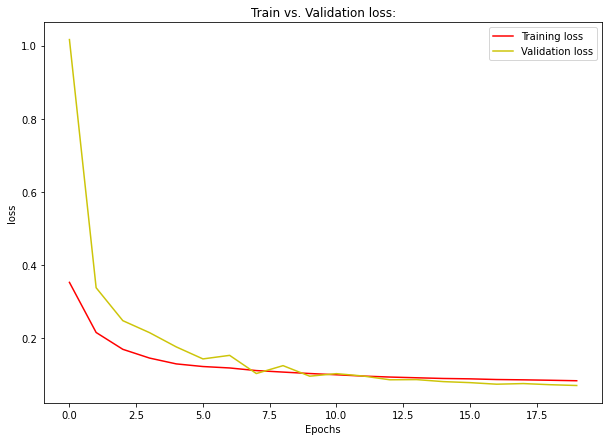

time: 185 ms (started: 2022-06-29 23:47:54 +00:00)


In [ ]:
plt.figure(figsize=(10, 7))
line_loss = plt.plot(range(0,len(history.history['loss'])), history.history['loss'], 'r')
line_val = plt.plot(range(0,len(history.history['val_loss'])), history.history['val_loss'], '#cdc50a')
plt.title('Train vs. Validation loss:')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'])
print('\n')

Validation loss is slightly higher that training loss.

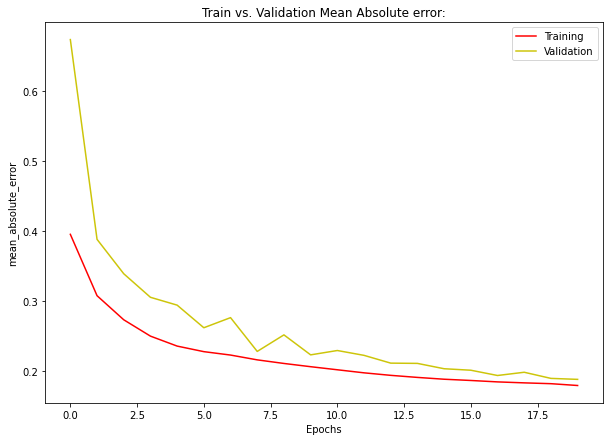

time: 184 ms (started: 2022-06-29 23:47:55 +00:00)


In [ ]:
plt.figure(figsize=(10, 7))
line_train = plt.plot(range(0,len(history.history['mean_absolute_error'])), history.history['mean_absolute_error'], 'r')
line_val = plt.plot(range(0,len(history.history['val_mean_absolute_error'])), history.history['val_mean_absolute_error'], '#cdc50a')
plt.title('Train vs. Validation Mean Absolute error:')
plt.ylabel('mean_absolute_error')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])
print('\n')

### derive predictions

In [ ]:
# a helper function that retruns the predictions after passing the testing 
# data set of the WindowGeneratotr object as input parameter 
# to the predict function of the model, basic_lstm_model
prediction_res_bi = derivePredictions(bi_directional)

The shape of the predictions : (4994, 1, 1)
time: 1.21 s (started: 2022-06-29 23:47:55 +00:00)


### Denormalize the predictions

In [ ]:
# using a helper function to denormalize the predictions and return data frame
predicted_traffic_volume_df_bi= denormalizeDataFile(prediction_res_bi)

time: 1.26 s (started: 2022-06-29 23:47:56 +00:00)


In [ ]:
# the top 5 records
predicted_traffic_volume_df_bi.head()

,prediction
id,
1,2338.664971
2,5540.121787
3,6526.142810
4,5544.311808
5,4447.407827


time: 6.43 ms (started: 2022-06-29 23:47:57 +00:00)


### Write the predictions to a csv file.

In [ ]:
# a helper function that recieves a data frame as an argument 
# and writes the contents of the data frame to a csv file
writePredictionsToCsv(predicted_traffic_volume_df_bi)

time: 16.7 ms (started: 2022-06-29 23:47:57 +00:00)


## HyperParameter Tuning

### Batch size
<p>These are the number of training examples at a time the network for
training. The choice of the mini‐batch size should relatively be independent of other
hyper‐parameters.Too small of a size , you don’t take full advantage of the benefits of
the matrix libraries optimized for Hardware like how Michael Nielsen mentions in the
NNDL book and too large, you are simply not updating your weights often enough.
So, trying out different values of  32, 64, 80, 100, 128, 256.</p>

In [ ]:
history_D = {}
batch_size_L = [1, 2, 4, 8, 16, 32, 64, 80, 100, 128, 256]
recordTime_L = []                             # list of run time execution for each mini batch size
val_performance_bs = {}
performance_bs = {}
train_performance_bs = {}
MAX_EPOCHS = 100
early_stopping = EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min', verbose=1)
for batch_size in range(len(batch_size_L)):
  print('Executing batch size : %s' %str(batch_size_L[batch_size]))
  
  bi_directional = Sequential()
  # research about input_shape = (n_input, n_features)
  bi_directional.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True, input_shape=(5, 9))))
  bi_directional.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
  bi_directional.add(Dense(1))
  bi_directional.add(Reshape([1, -1]))

  bi_directional.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  # startime
  startTime = time.time()

  history = bi_directional.fit(window_5_1_2.train, epochs=MAX_EPOCHS
                                , batch_size=batch_size_L[batch_size]
                                ,validation_data=window_5_1_2.val
                                ,callbacks=[early_stopping])
  endTime = time.time()

  recordTime_L.append((batch_size_L[batch_size], endTime - startTime))
  
  # insert the history of the current execution into a dictionary.
  history_D[batch_size_L[batch_size]] = history

  #IPython.display.clear_output()
  train_performance_bs[str(batch_size_L[batch_size])] = bi_directional.evaluate(window_5_1_2.train)
  val_performance_bs[str(batch_size_L[batch_size])] = bi_directional.evaluate(window_5_1_2.val)
  performance_bs[str(batch_size_L[batch_size])] = bi_directional.evaluate(window_5_1_2.test, verbose=0)

Executing batch size : 1
Epoch 1/100
778/778 [==============================] - 32s 36ms/step - loss: 0.3028 - mean_absolute_error: 0.3762 - val_loss: 1.4434 - val_mean_absolute_error: 0.7409
Epoch 2/100
778/778 [==============================] - 27s 34ms/step - loss: 0.7741 - mean_absolute_error: 0.3123 - val_loss: 0.4094 - val_mean_absolute_error: 0.4295
Epoch 3/100
778/778 [==============================] - 27s 35ms/step - loss: 0.4569 - mean_absolute_error: 0.2852 - val_loss: 0.3165 - val_mean_absolute_error: 0.3722
Epoch 4/100
778/778 [==============================] - 27s 34ms/step - loss: 0.1507 - mean_absolute_error: 0.2559 - val_loss: 0.1822 - val_mean_absolute_error: 0.2919
Epoch 5/100
778/778 [==============================] - 26s 34ms/step - loss: 0.1369 - mean_absolute_error: 0.2425 - val_loss: 0.1974 - val_mean_absolute_error: 0.2957
Epoch 6/100
778/778 [==============================] - 27s 34ms/step - loss: 0.1284 - mean_absolute_error: 0.2319 - val_loss: 0.1367 - val_m

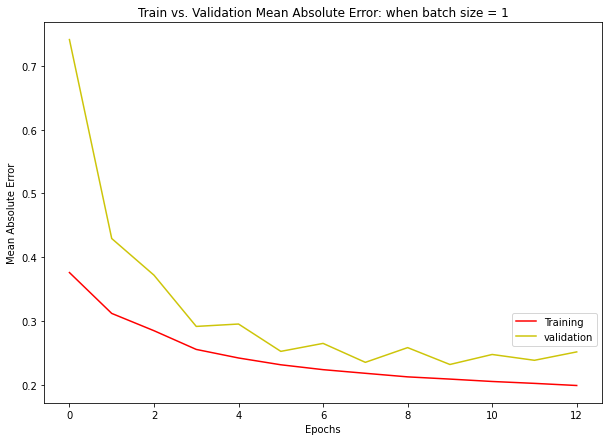

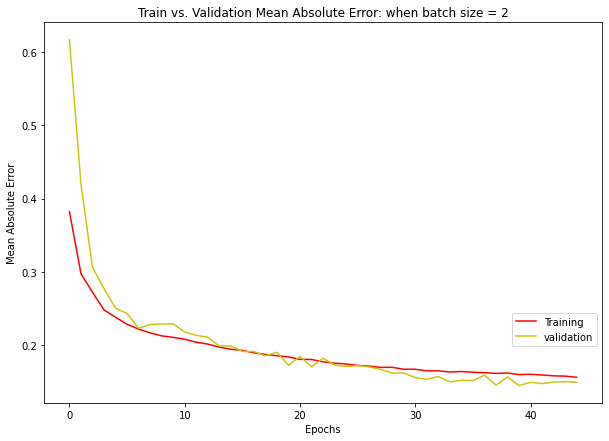

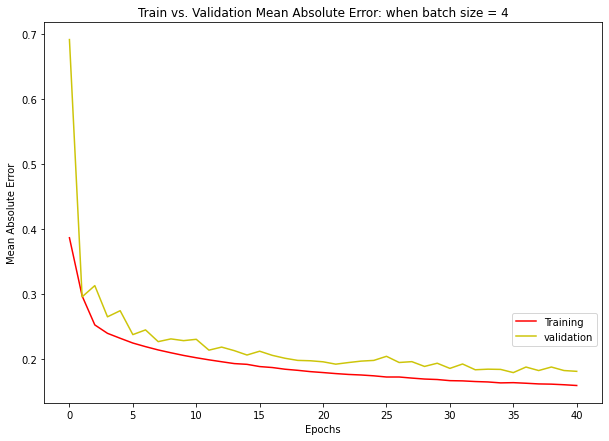

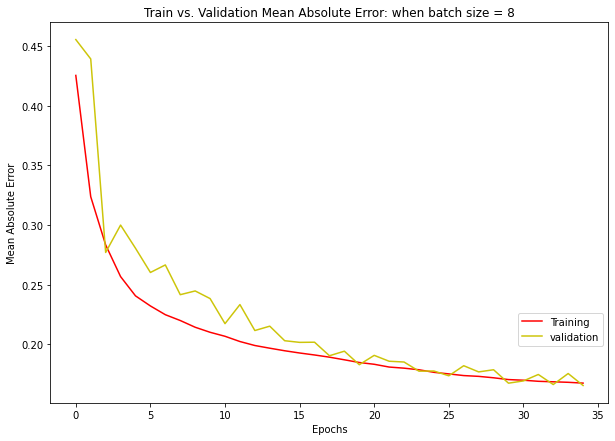

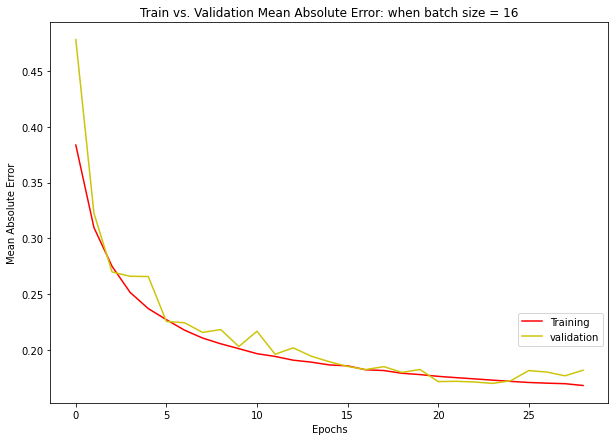

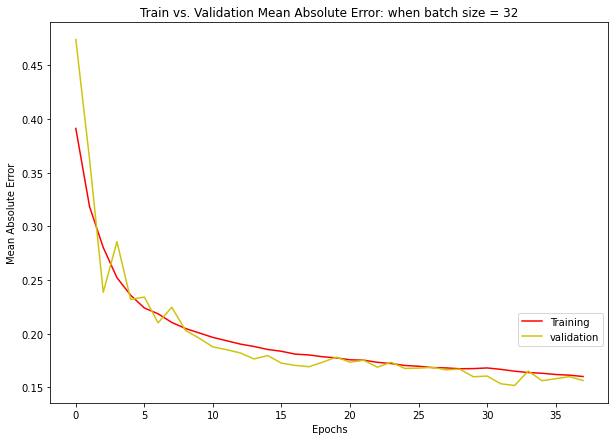

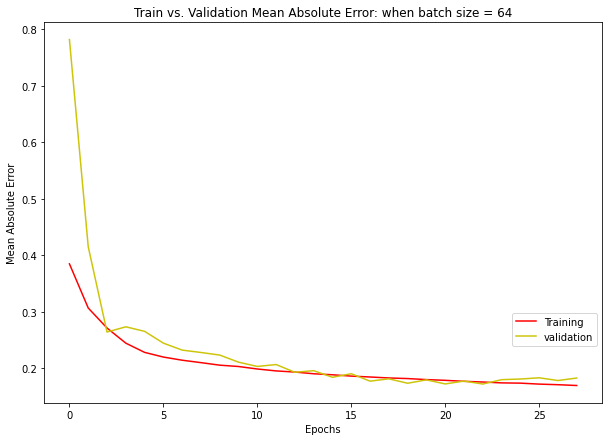

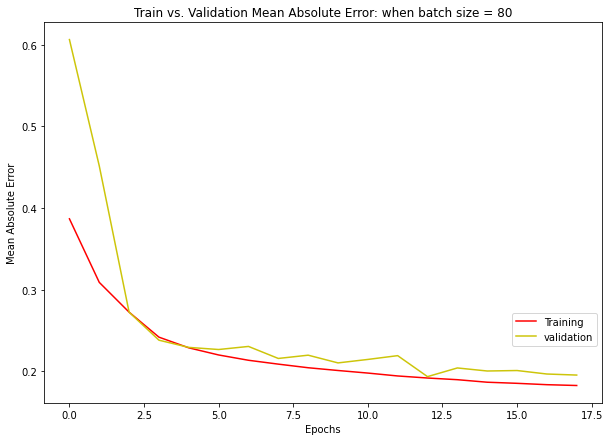

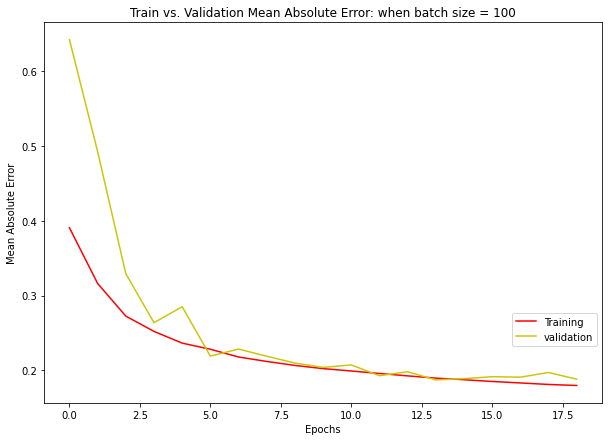

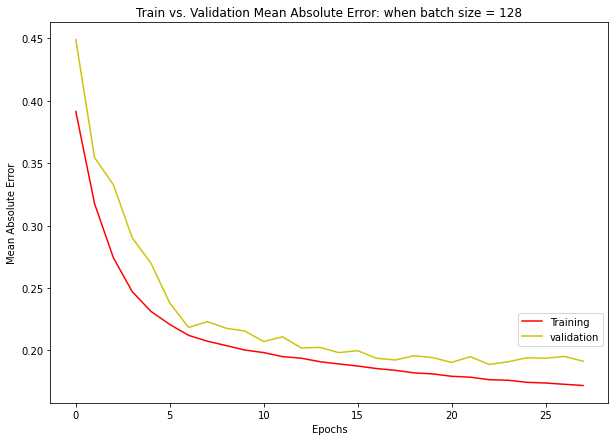

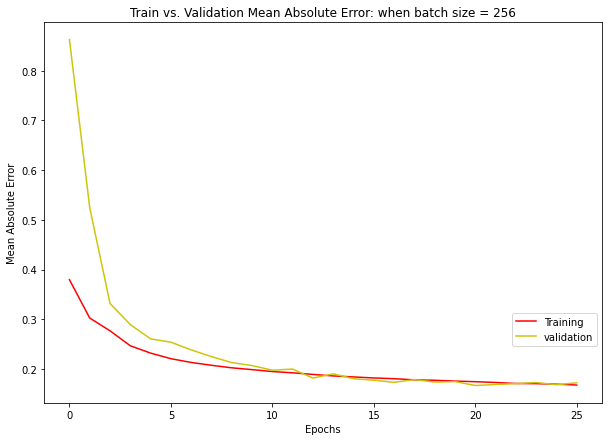

time: 2.11 s (started: 2022-06-30 02:14:30 +00:00)


In [ ]:
# helper function that generates performance plots
generatePlot_mae(history_D, 100, 'batch size')

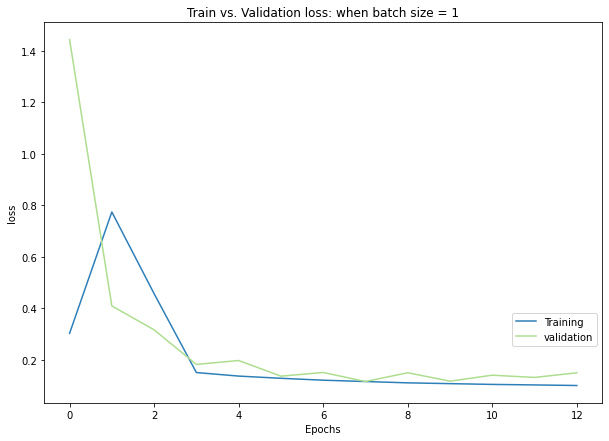

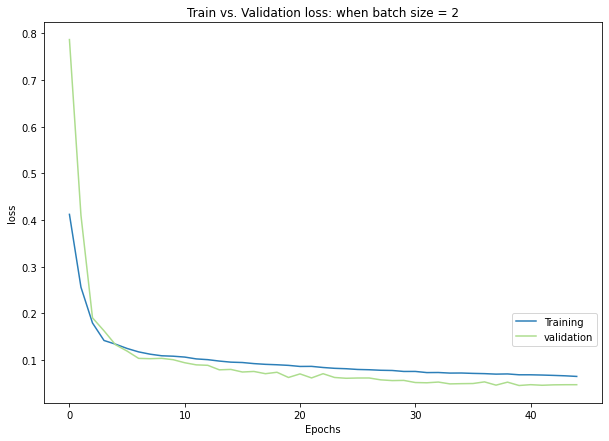

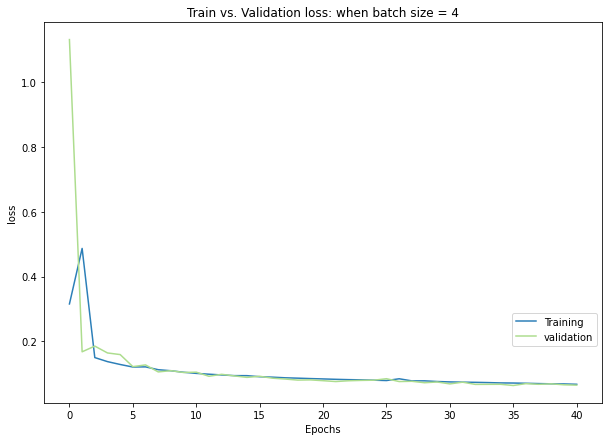

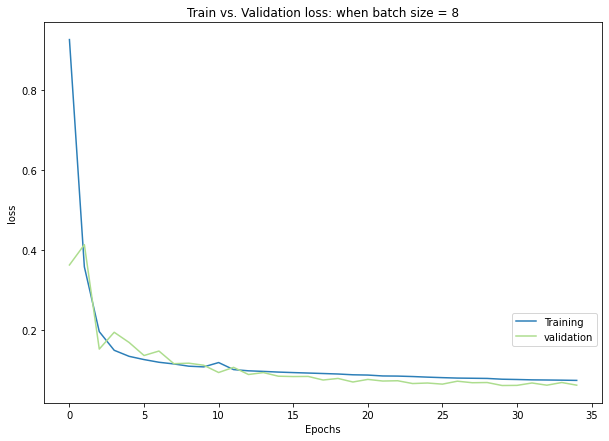

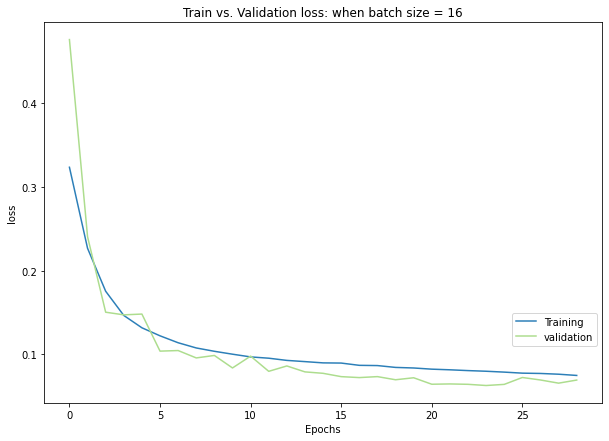

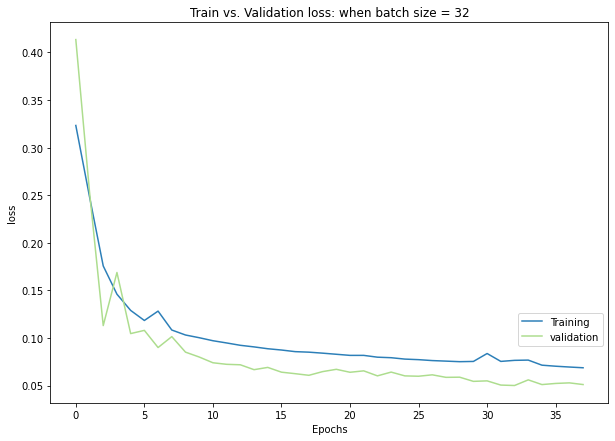

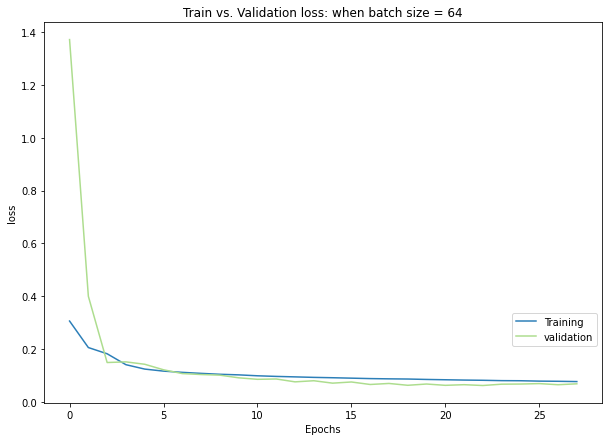

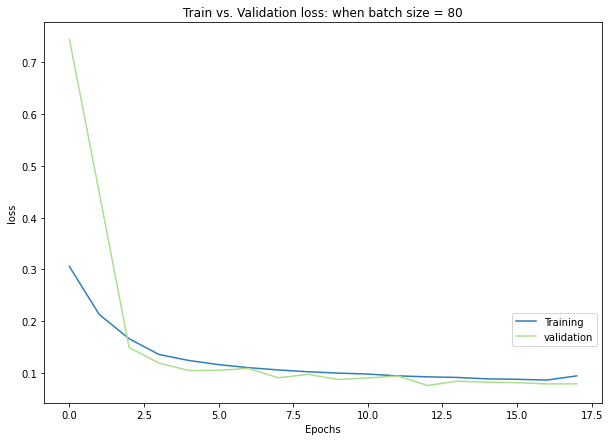

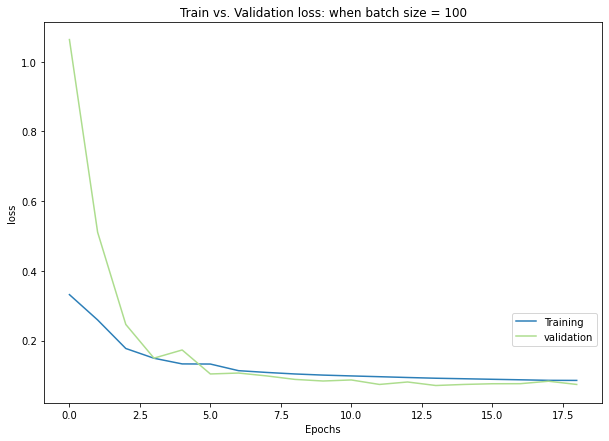

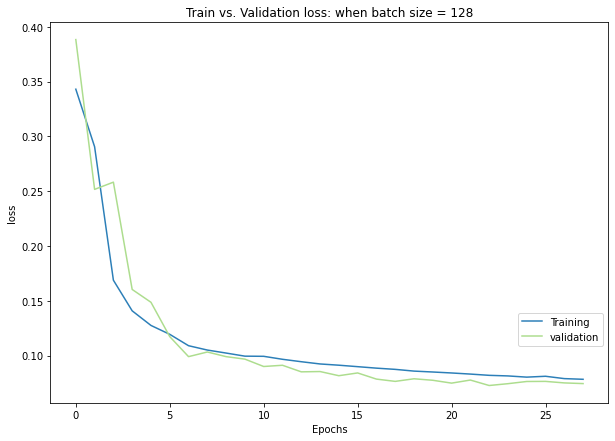

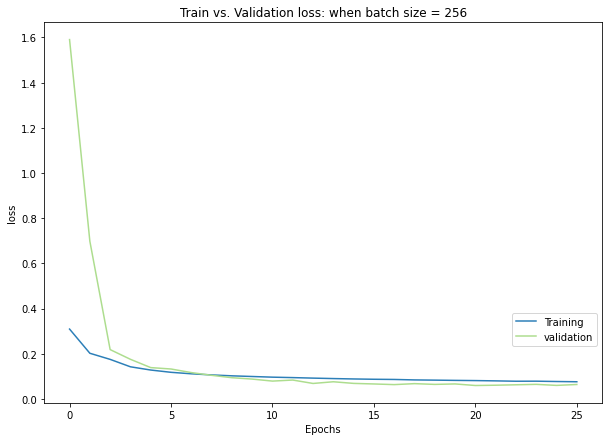

time: 2.06 s (started: 2022-06-30 02:14:33 +00:00)


In [ ]:
# helper function that generates the plots for the different hyper parameters:
generate_loss_Plot(history_D, 100, 'batch size')

Create Different Pandas data frame for analysis.

In [ ]:
# a helper function that derives the data frame for the train_loss_mae, val_loss_mae, test_loss_mae
train_loss_mae_bs_df, val_loss_mae_bs_df, test_loss_mae_bs_df, recordTime_df = deriveDataFrame(train_performance_bs,val_performance_bs, performance_bs, 'batch_size', recordTime_L)

time: 10.2 ms (started: 2022-06-30 02:14:35 +00:00)


In [ ]:
train_loss_mae_bs_df

,batch_size,loss,mae
0,1,0.225279,0.305640
1,2,0.084592,0.184467
2,4,0.105909,0.209949
3,8,0.112358,0.204964
4,16,0.111049,0.215560
5,32,0.091202,0.190881
6,64,0.114291,0.219042
7,80,0.137440,0.243646
8,100,0.126000,0.232838
9,128,0.120462,0.228232


time: 7.41 ms (started: 2022-06-30 02:14:35 +00:00)


In [ ]:
val_loss_mae_bs_df

,batch_size,val_loss,val_mae
0,1,0.149764,0.252062
1,2,0.047120,0.149434
2,4,0.065224,0.180836
3,8,0.063024,0.165334
4,16,0.069341,0.181912
5,32,0.051035,0.156435
6,64,0.067452,0.182667
7,80,0.079626,0.195193
8,100,0.074047,0.188294
9,128,0.074399,0.191450


time: 7.33 ms (started: 2022-06-30 02:14:35 +00:00)


In [ ]:
test_loss_mae_bs_df

,batch_size,test_loss,test_mae
0,1,0.219934,0.315280
1,2,0.039703,0.144619
2,4,0.067017,0.184689
3,8,0.066276,0.168379
4,16,0.069019,0.189961
5,32,0.046465,0.154275
6,64,0.071006,0.191162
7,80,0.094105,0.224482
8,100,0.081504,0.206935
9,128,0.077615,0.203698


time: 7.06 ms (started: 2022-06-30 02:14:35 +00:00)


In [ ]:
performance_bs

{'1': [0.2199338972568512, 0.3152795135974884],
 '100': [0.0815042108297348, 0.2069346308708191],
 '128': [0.07761518657207489, 0.20369821786880493],
 '16': [0.06901947408914566, 0.1899605542421341],
 '2': [0.03970259800553322, 0.1446186900138855],
 '256': [0.06618364155292511, 0.17958594858646393],
 '32': [0.04646521434187889, 0.1542753130197525],
 '4': [0.06701722741127014, 0.18468937277793884],
 '64': [0.07100582867860794, 0.19116218388080597],
 '8': [0.06627555191516876, 0.1683788299560547],
 '80': [0.09410546720027924, 0.22448204457759857]}

time: 3.36 ms (started: 2022-06-30 02:14:35 +00:00)


In [ ]:
train_df.shape

(24902, 9)

time: 3.09 ms (started: 2022-06-30 02:14:35 +00:00)


In [ ]:
test_df.shape

(5000, 9)

time: 2.99 ms (started: 2022-06-30 02:14:35 +00:00)


Lets trying running diffrent models for the individual batch sizes: 2, 4, and 8

In [ ]:
def deriveModel_WithBatch_size(batch_size):
  train_performance_bs, val_performance_bs, performance_bs = {}, {}, {}
  
  bi_directional = Sequential()
  # research about input_shape = (n_input, n_features)
  bi_directional.add(Bidirectional(LSTM(32, activation='relu')))
  bi_directional.add(Dense(1))

  bi_directional.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  # startime
  startTime = time.time()

  history = bi_directional.fit(window_5_1_2.train, epochs=MAX_EPOCHS
                                , batch_size=batch_size
                                                   ,validation_data=window_5_1_2.val)
  endTime = time.time()

  recordTime_L.append((str(batch_size), endTime - startTime))
  
  # insert the history of the current execution into a dictionary.
  history_D[str(batch_size)] = history
  #val_loss, val_mean_absolute_error = bi_directional.evaluate(window_5_1_2.val)
  #train_loss, mean_absolute_error = bi_directional.evaluate(window_5_1_2.train)
  #test_loss, test_mean_absolute_error = bi_directional.evaluate(window_5_1_2.test)

  #IPython.display.clear_output()
  train_performance_bs[str(batch_size)] = bi_directional.evaluate(window_5_1_2.train)
  val_performance_bs[str(batch_size)] = bi_directional.evaluate(window_5_1_2.val)
  performance_bs[str(batch_size)] = bi_directional.evaluate(window_5_1_2.test, verbose=0)

  return  bi_directional, train_performance_bs, val_performance_bs, performance_bs

time: 12.9 ms (started: 2022-06-30 02:14:35 +00:00)


#### Running the individual batch sizes.

In [ ]:
bi_directional_2, train_performance_bs_2, val_performance_bs_2, performance_bs_2 = deriveModel_WithBatch_size(2)

Epoch 1/100
778/778 [==============================] - 16s 17ms/step - loss: 0.3086 - mean_absolute_error: 0.3866 - val_loss: 0.8694 - val_mean_absolute_error: 0.6472
Epoch 2/100
778/778 [==============================] - 13s 17ms/step - loss: 0.2317 - mean_absolute_error: 0.3207 - val_loss: 0.1882 - val_mean_absolute_error: 0.3244
Epoch 3/100
778/778 [==============================] - 14s 17ms/step - loss: 0.2356 - mean_absolute_error: 0.2996 - val_loss: 0.1238 - val_mean_absolute_error: 0.2618
Epoch 4/100
778/778 [==============================] - 13s 17ms/step - loss: 0.1693 - mean_absolute_error: 0.2786 - val_loss: 0.1075 - val_mean_absolute_error: 0.2473
Epoch 5/100
778/778 [==============================] - 13s 17ms/step - loss: 0.1495 - mean_absolute_error: 0.2598 - val_loss: 0.0966 - val_mean_absolute_error: 0.2286
Epoch 6/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1366 - mean_absolute_error: 0.2452 - val_loss: 0.0971 - val_mean_absolute_error: 0.228

In [ ]:
bi_directional_4, train_performance_bs_4, val_performance_bs_4, performance_bs_4 = deriveModel_WithBatch_size(4)

Epoch 1/100
778/778 [==============================] - 16s 18ms/step - loss: 0.4019 - mean_absolute_error: 0.4104 - val_loss: 1.4061 - val_mean_absolute_error: 0.8139
Epoch 2/100
778/778 [==============================] - 14s 18ms/step - loss: 0.2409 - mean_absolute_error: 0.3333 - val_loss: 0.2113 - val_mean_absolute_error: 0.3349
Epoch 3/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1909 - mean_absolute_error: 0.2996 - val_loss: 0.1289 - val_mean_absolute_error: 0.2730
Epoch 4/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1700 - mean_absolute_error: 0.2807 - val_loss: 0.1341 - val_mean_absolute_error: 0.2707
Epoch 5/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1588 - mean_absolute_error: 0.2637 - val_loss: 0.0953 - val_mean_absolute_error: 0.2301
Epoch 6/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1492 - mean_absolute_error: 0.2532 - val_loss: 0.0956 - val_mean_absolute_error: 0.225

In [ ]:
bi_directional_8, train_performance_bs_8, val_performance_bs_8, performance_bs_8 = deriveModel_WithBatch_size(8)

Epoch 1/100
778/778 [==============================] - 16s 18ms/step - loss: 0.3366 - mean_absolute_error: 0.3960 - val_loss: 0.5498 - val_mean_absolute_error: 0.5002
Epoch 2/100
778/778 [==============================] - 14s 18ms/step - loss: 0.2541 - mean_absolute_error: 0.3170 - val_loss: 0.1993 - val_mean_absolute_error: 0.3417
Epoch 3/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1867 - mean_absolute_error: 0.2924 - val_loss: 0.1716 - val_mean_absolute_error: 0.2969
Epoch 4/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1667 - mean_absolute_error: 0.2722 - val_loss: 0.1394 - val_mean_absolute_error: 0.2743
Epoch 5/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1491 - mean_absolute_error: 0.2576 - val_loss: 0.1132 - val_mean_absolute_error: 0.2382
Epoch 6/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1368 - mean_absolute_error: 0.2447 - val_loss: 0.1260 - val_mean_absolute_error: 0.253

In [ ]:
bi_directional_16, train_performance_bs_16, val_performance_bs_16, performance_bs_16 = deriveModel_WithBatch_size(16)

Epoch 1/100
778/778 [==============================] - 16s 18ms/step - loss: 0.3270 - mean_absolute_error: 0.3912 - val_loss: 0.4888 - val_mean_absolute_error: 0.5169
Epoch 2/100
778/778 [==============================] - 14s 17ms/step - loss: 0.2135 - mean_absolute_error: 0.3124 - val_loss: 0.3309 - val_mean_absolute_error: 0.3961
Epoch 3/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1821 - mean_absolute_error: 0.2894 - val_loss: 0.2018 - val_mean_absolute_error: 0.3368
Epoch 4/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1667 - mean_absolute_error: 0.2732 - val_loss: 0.1925 - val_mean_absolute_error: 0.3011
Epoch 5/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1442 - mean_absolute_error: 0.2544 - val_loss: 0.2604 - val_mean_absolute_error: 0.3372
Epoch 6/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1332 - mean_absolute_error: 0.2426 - val_loss: 0.1088 - val_mean_absolute_error: 0.243

In [ ]:
bi_directional_32, train_performance_bs_32, val_performance_bs_32, performance_bs_32 = deriveModel_WithBatch_size(32)

Epoch 1/100
778/778 [==============================] - 16s 18ms/step - loss: 0.4933 - mean_absolute_error: 0.4197 - val_loss: 1.2308 - val_mean_absolute_error: 0.6687
Epoch 2/100
778/778 [==============================] - 14s 18ms/step - loss: 0.2303 - mean_absolute_error: 0.3216 - val_loss: 0.2139 - val_mean_absolute_error: 0.3435
Epoch 3/100
778/778 [==============================] - 14s 17ms/step - loss: 0.1949 - mean_absolute_error: 0.2975 - val_loss: 0.2072 - val_mean_absolute_error: 0.3196
Epoch 4/100
778/778 [==============================] - 14s 17ms/step - loss: 0.1764 - mean_absolute_error: 0.2792 - val_loss: 0.1603 - val_mean_absolute_error: 0.3009
Epoch 5/100
778/778 [==============================] - 14s 17ms/step - loss: 0.1614 - mean_absolute_error: 0.2638 - val_loss: 0.1189 - val_mean_absolute_error: 0.2557
Epoch 6/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1454 - mean_absolute_error: 0.2501 - val_loss: 0.1157 - val_mean_absolute_error: 0.249

In [ ]:
bi_directional_1, train_performance_bs_1, val_performance_bs_1, performance_bs_1 = deriveModel_WithBatch_size(1)

Epoch 1/100
778/778 [==============================] - 16s 18ms/step - loss: 0.3160 - mean_absolute_error: 0.3846 - val_loss: 0.4383 - val_mean_absolute_error: 0.4410
Epoch 2/100
778/778 [==============================] - 14s 18ms/step - loss: 0.3933 - mean_absolute_error: 0.3201 - val_loss: 0.1768 - val_mean_absolute_error: 0.3194
Epoch 3/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1908 - mean_absolute_error: 0.2981 - val_loss: 0.1434 - val_mean_absolute_error: 0.2775
Epoch 4/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1706 - mean_absolute_error: 0.2818 - val_loss: 0.1137 - val_mean_absolute_error: 0.2532
Epoch 5/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1561 - mean_absolute_error: 0.2674 - val_loss: 0.0890 - val_mean_absolute_error: 0.2251
Epoch 6/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1439 - mean_absolute_error: 0.2524 - val_loss: 0.0875 - val_mean_absolute_error: 0.218

In [ ]:
val_performance_bs_1

{'1': [0.05394664406776428, 0.16220882534980774]}

time: 4.19 ms (started: 2022-06-30 04:33:47 +00:00)


In [ ]:
val_performance_bs_2

{'2': [0.05849886313080788, 0.17037497460842133]}

time: 3.92 ms (started: 2022-06-30 04:33:47 +00:00)


In [ ]:
val_performance_bs_4

{'4': [0.05889371782541275, 0.17051398754119873]}

time: 3.14 ms (started: 2022-06-30 04:33:47 +00:00)


In [ ]:
val_performance_bs_8

{'8': [0.06211744621396065, 0.17909307777881622]}

time: 3.69 ms (started: 2022-06-30 04:33:47 +00:00)


In [ ]:
val_performance_bs_16

{'16': [0.057447824627161026, 0.16913336515426636]}

time: 2.94 ms (started: 2022-06-30 04:33:47 +00:00)


In [ ]:
val_performance_bs_32

{'32': [0.0700143575668335, 0.18205608427524567]}

time: 2.63 ms (started: 2022-06-30 04:33:47 +00:00)


In [ ]:
MAX_EPOCHS = 100
val_performance_2 = {}
performance_2 = {}
bi_directional_2 = Sequential()
# research about input_shape = (n_input, n_features)
bi_directional_2.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
bi_directional_2.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
bi_directional_2.add(Dense(1))
bi_directional_2.add(Reshape([1, -1]))

# compile the model 
bi_directional_2.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
# fit the data with model
history_D2 = bi_directional_2.fit(window_5_1_2.train, epochs=MAX_EPOCHS, batch_size=2,
                                                   validation_data=window_5_1_2.val
                            )


IPython.display.clear_output()
val_performance_2['Bidirectional'] = bi_directional_2.evaluate(window_5_1_2.val)
performance_2['Bidirectional'] = bi_directional_2.evaluate(window_5_1_2.test, verbose=0)

334/334 [==============================] - 2s 5ms/step - loss: 0.0628 - mean_absolute_error: 0.1692
time: 46min 20s (started: 2022-06-30 04:33:47 +00:00)


Regardless of the batch size you use, it doesn't have any impact on the mae. 

### Learning rate

In [ ]:
history_D_lr = {}
#val_loss_L = []                               # list of val_loss
#val_accuracy_L = []                           # list of val accuracy
learningRate_L = [0.5, 0.25, 0.01, 0.15, 0.02, 0.025, 0.002, 0.001]
recordTime_L = []                             # list of run time execution for each mini batch size
val_performance_lr = {}
performance_lr = {}
train_performance_lr = {}
MAX_EPOCHS = 100
early_stopping = EarlyStopping(monitor='val_loss',
                                                    patience=45,
                                                    mode='min', verbose=1)
#cp = ModelCheckpoint('./model.h5', monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)
for lr in range(len(learningRate_L)):
  print('Executing Learning rate  : %s' %str(learningRate_L[lr]))
  
  bi_directional_lr = Sequential()
  # research about input_shape = (n_input, n_features)
  bi_directional_lr.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
  
  bi_directional_lr.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
  bi_directional_lr.add(Dense(1))
  bi_directional_lr.add(Reshape([1, -1]))

  # set the learning rate
  opt = tf.optimizers.Adam(learning_rate=learningRate_L[lr])
  bi_directional_lr.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])
  # startime
  startTime = time.time()

  history = bi_directional_lr.fit(window_5_1_2.train, epochs=MAX_EPOCHS
                                ,batch_size=16
                                                   ,validation_data=window_5_1_2.val, callbacks=[early_stopping])
  endTime = time.time()

  recordTime_L.append((learningRate_L[lr], endTime - startTime))
  
  # insert the history of the current execution into a dictionary.
  history_D_lr[learningRate_L[lr]] = history
  #val_loss, val_mean_absolute_error = bi_directional.evaluate(window_5_1_2.val)
  #train_loss, mean_absolute_error = bi_directional.evaluate(window_5_1_2.train)
  #test_loss, test_mean_absolute_error = bi_directional.evaluate(window_5_1_2.test)

  IPython.display.clear_output()
  train_performance_lr[str(learningRate_L[lr])] = bi_directional_lr.evaluate(window_5_1_2.train)
  val_performance_lr[str(learningRate_L[lr])] = bi_directional_lr.evaluate(window_5_1_2.val)
  performance_lr[str(learningRate_L[lr])] = bi_directional_lr.evaluate(window_5_1_2.test, verbose=0)

334/334 [==============================] - 2s 5ms/step - loss: 0.0636 - mean_absolute_error: 0.1798
time: 4h 51min 4s (started: 2022-06-30 05:20:07 +00:00)


In [ ]:
history_D_lr

{0.001: <keras.callbacks.History at 0x7fdb20f0b650>,
 0.002: <keras.callbacks.History at 0x7fdb20f9e0d0>,
 0.01: <keras.callbacks.History at 0x7fdb2ba153d0>,
 0.02: <keras.callbacks.History at 0x7fdb237b4d90>,
 0.025: <keras.callbacks.History at 0x7fdb1eed9fd0>,
 0.15: <keras.callbacks.History at 0x7fdb26c82490>,
 0.25: <keras.callbacks.History at 0x7fdb2bf23350>,
 0.5: <keras.callbacks.History at 0x7fdb26f666d0>}

time: 3.85 ms (started: 2022-06-30 10:11:12 +00:00)


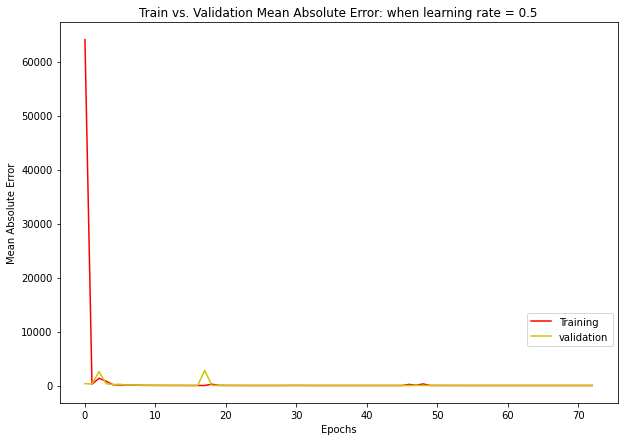

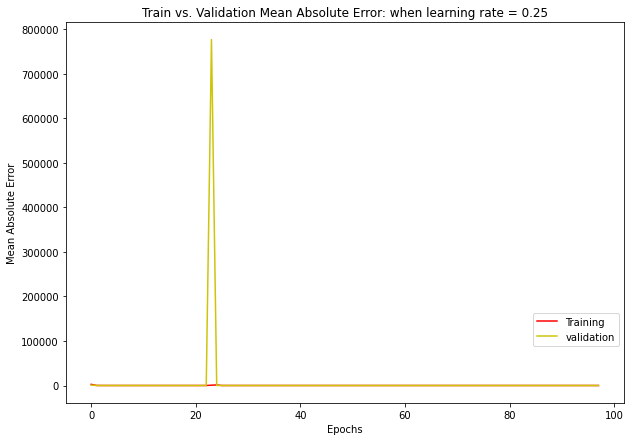

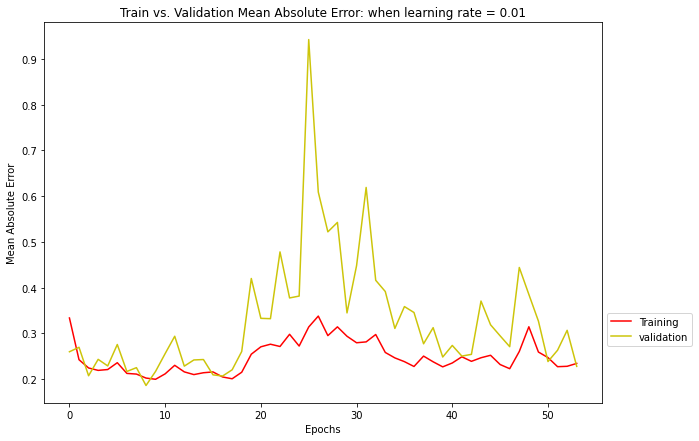

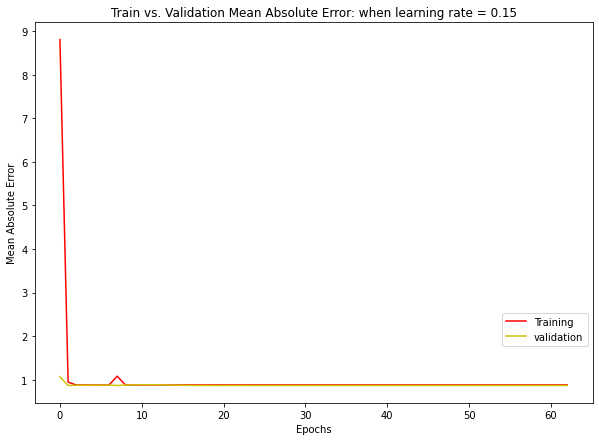

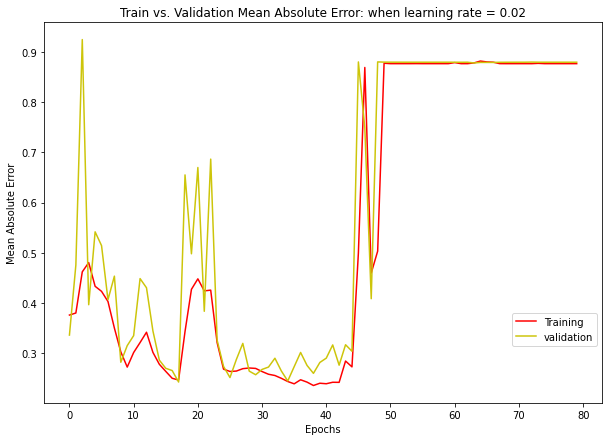

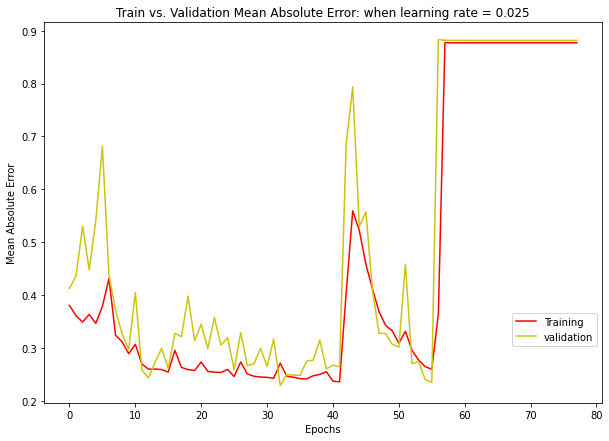

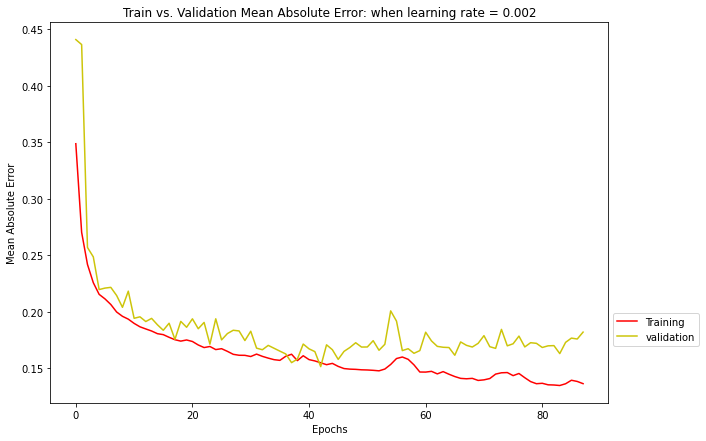

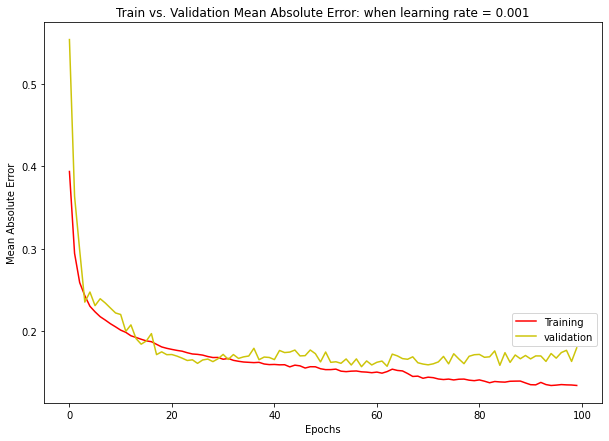

time: 1.62 s (started: 2022-06-30 10:11:12 +00:00)


In [ ]:
# helper function that generates performance plots
generatePlot_mae(history_D_lr, 100, 'learning rate')

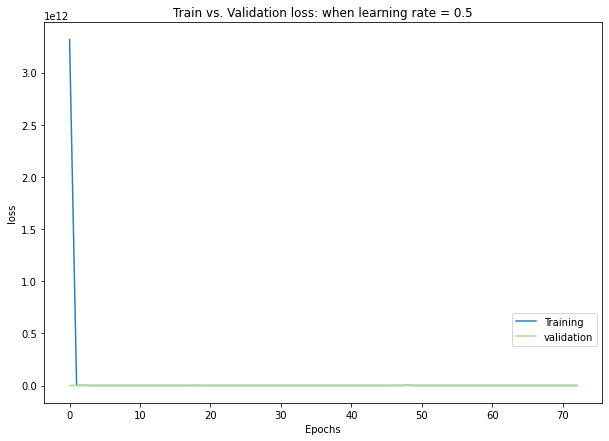

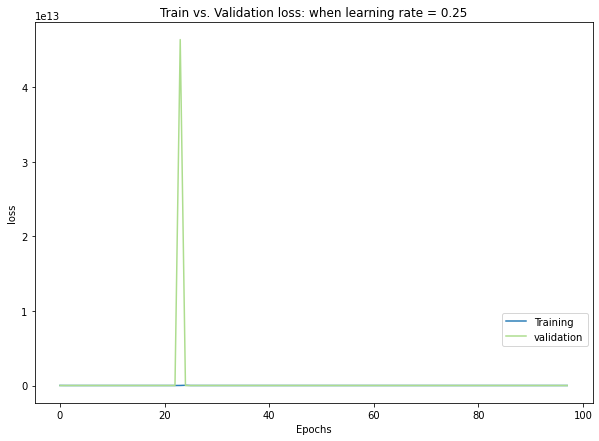

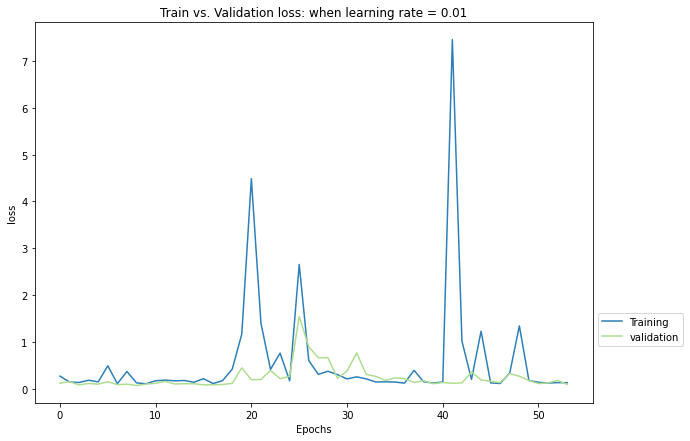

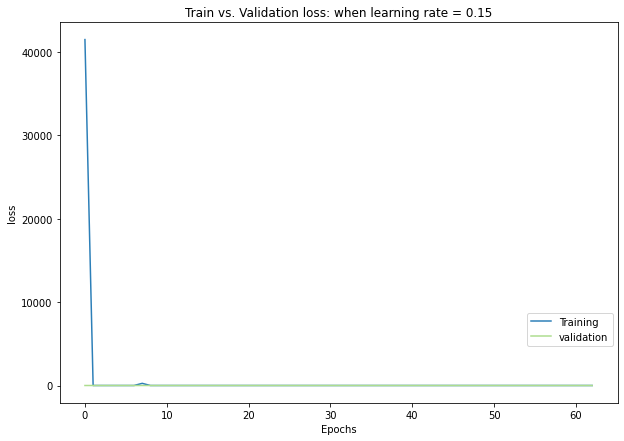

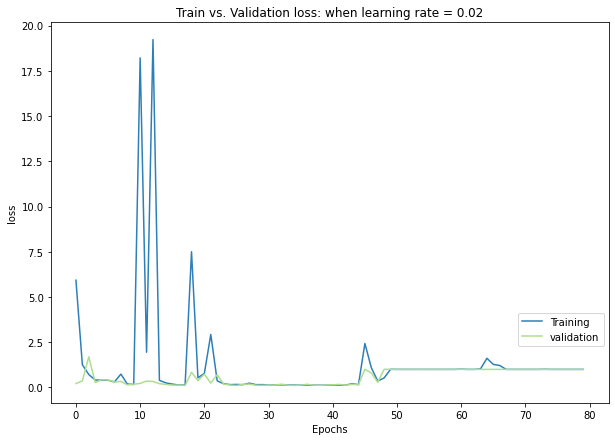

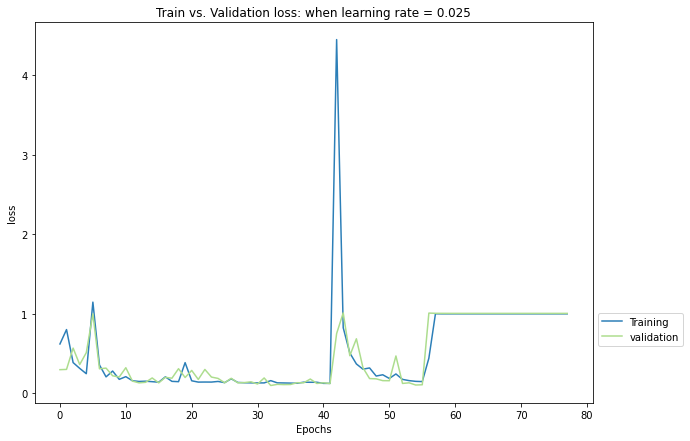

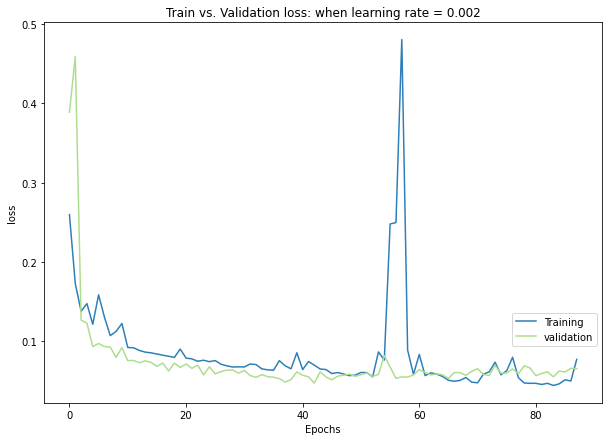

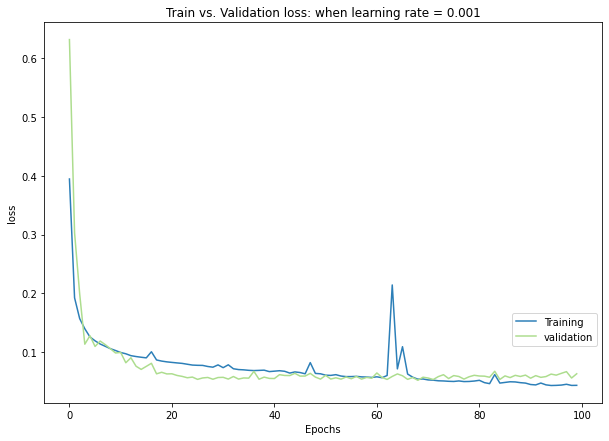

time: 1.51 s (started: 2022-06-30 10:11:13 +00:00)


In [ ]:
# helper function that generates the plots for the different hyper parameters:
generate_loss_Plot(history_D_lr, 100, 'learning rate')

Create Different Pandas data frame for analysis.

In [ ]:
# a helper function that derives the data frame for the train_loss_mae, val_loss_mae, test_loss_mae
train_loss_mae_lr_df, val_loss_mae_lr_df, test_loss_mae_lr_df, recordTime_df = deriveDataFrame(train_performance_lr,val_performance_lr, performance_lr, 'learningRate', recordTime_L)

time: 9.05 ms (started: 2022-06-30 10:11:15 +00:00)


In [ ]:
train_loss_mae_lr_df

,batch_size,loss,mae
0,0.5,1.033802,0.881472
1,0.25,1.000651,0.877158
2,0.01,0.386909,0.278592
3,0.15,1.003199,0.877104
4,0.02,1.010970,0.882950
5,0.025,1.013135,0.883782
6,0.002,0.083860,0.187848
7,0.001,0.117477,0.196370


time: 7.58 ms (started: 2022-06-30 10:11:15 +00:00)


In [ ]:
val_loss_mae_lr_df

,learningRate,val_loss,val_mae
0,0.5,625.374268,1.117479
1,0.25,12.164798,0.908097
2,0.01,0.092424,0.227785
3,0.15,0.981996,0.866779
4,0.02,1.001960,0.880203
5,0.025,1.004871,0.881529
6,0.002,0.065583,0.181878
7,0.001,0.063588,0.179754


time: 7.33 ms (started: 2022-06-30 10:11:15 +00:00)


In [ ]:
test_loss_mae_lr_df

,learningRate,test_loss,test_mae
0,0.5,1.409718,0.878142
1,0.25,0.996411,0.874002
2,0.01,0.093170,0.238109
3,0.15,0.995361,0.872052
4,0.02,1.021734,0.888125
5,0.025,1.025038,0.889735
6,0.002,0.060891,0.177368
7,0.001,0.057529,0.179276


time: 6.73 ms (started: 2022-06-30 10:11:15 +00:00)


From results above we see that the learning rate of 0.001 is more sufficent since it has a low validation loss and lower validation mean absolute error.

### Tunning Number of Recurrent units

In [ ]:
history_D_lr_ru = {}
#val_loss_L = []                               # list of val_loss
#val_accuracy_L = []                           # list of val accuracy
recurrent_units_L = [8, 16, 24, 32, 48, 50, 64, 80, 96, 100, 128, 150, 200]
recordTime_L = []                             # list of run time execution for each mini batch size
val_performance_lr_ru = {}
performance_lr_ru = {}
train_performance_lr_ru = {}
MAX_EPOCHS = 100
early_stopping = EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min', verbose=1)
for ru in range(len(recurrent_units_L)):
  print('Executing recurrent_unit  : %s' %str(recurrent_units_L[ru]))
  
  bi_directional_lr_ru = Sequential()
  # research about input_shape = (n_input, n_features)
  bi_directional_lr_ru.add(Bidirectional(LSTM(recurrent_units_L[ru], activation='relu', return_sequences=True, input_shape=(5, 9))))
  bi_directional_lr_ru.add(Bidirectional(LSTM(recurrent_units_L[ru], activation='relu', return_sequences=False)))
  #bi_directional_lr_001.add(Dense(32))
  bi_directional_lr_ru.add(Dense(1))
  bi_directional_lr_ru.add(Reshape([1, -1]))

  # set the learning rate
  opt = tf.optimizers.Adam(learning_rate=0.001)
  bi_directional_lr_ru.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])
  # startime
  startTime = time.time()

  history = bi_directional_lr_ru.fit(window_5_1_2.train, epochs=MAX_EPOCHS
                                ,batch_size=64
                                ,validation_data=window_5_1_2.val
                                , callbacks=[early_stopping])
  endTime = time.time()

  recordTime_L.append((recurrent_units_L[ru], endTime - startTime))
  
  # insert the history of the current execution into a dictionary.
  history_D_lr_ru[recurrent_units_L[ru]] = history

  IPython.display.clear_output()
  train_performance_lr_ru[str(recurrent_units_L[ru])] = bi_directional_lr_ru.evaluate(window_5_1_2.train)
  val_performance_lr_ru[str(recurrent_units_L[ru])] = bi_directional_lr_ru.evaluate(window_5_1_2.val)
  performance_lr_ru[str(recurrent_units_L[ru])] = bi_directional_lr_ru.evaluate(window_5_1_2.test, verbose=0)

334/334 [==============================] - 2s 6ms/step - loss: 0.0743 - mean_absolute_error: 0.1880
time: 3h 1min 15s (started: 2022-06-30 10:11:15 +00:00)


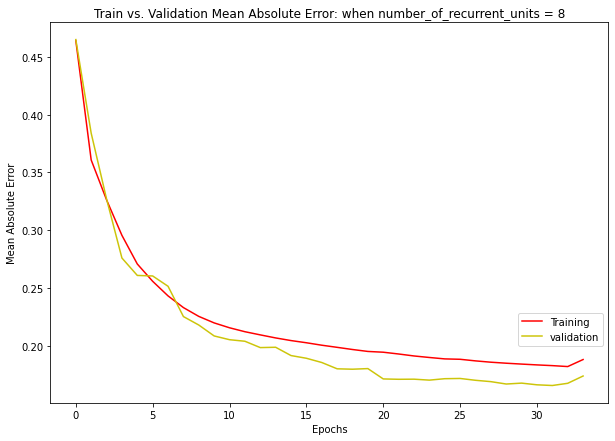

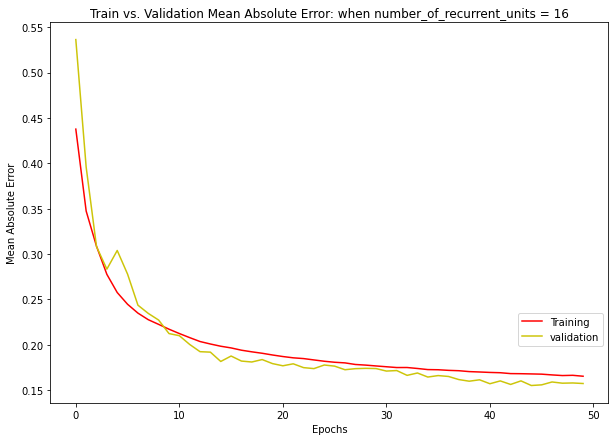

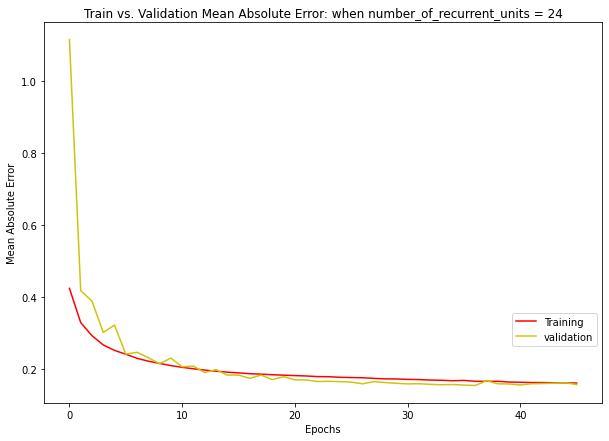

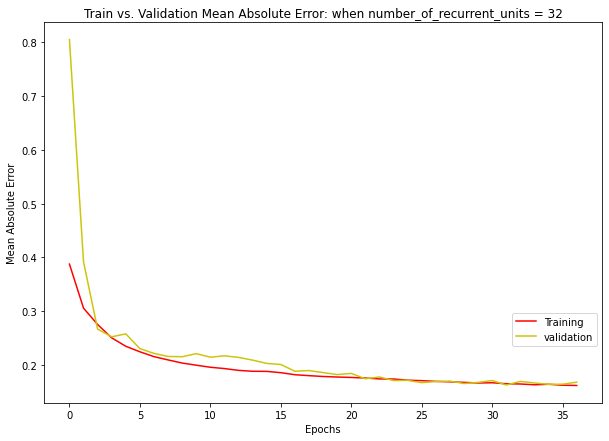

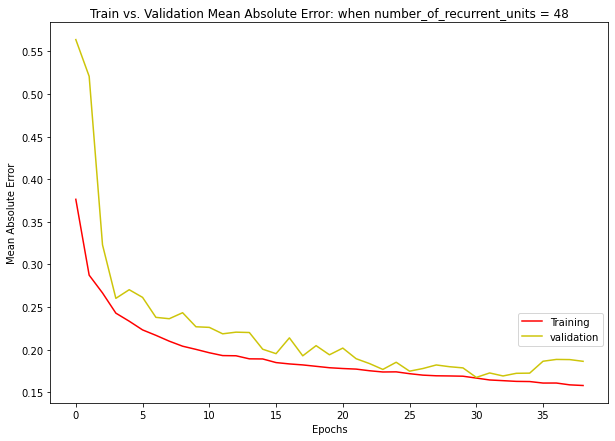

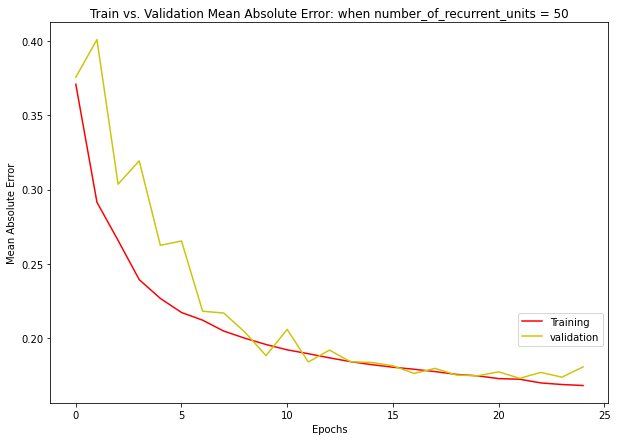

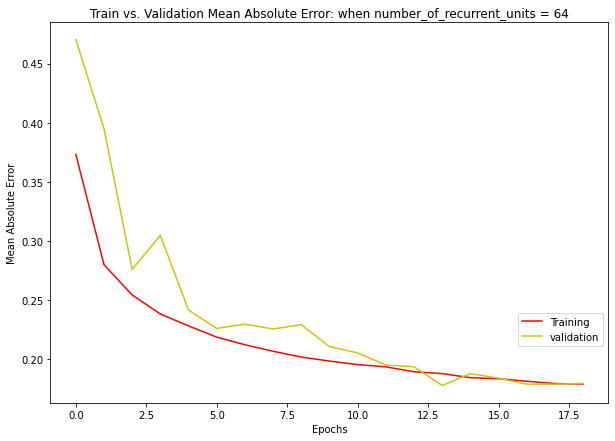

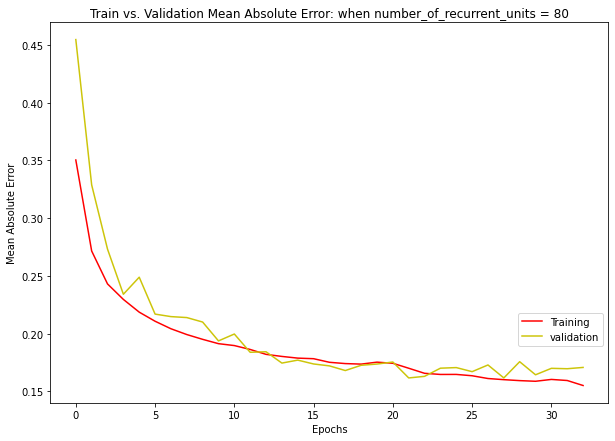

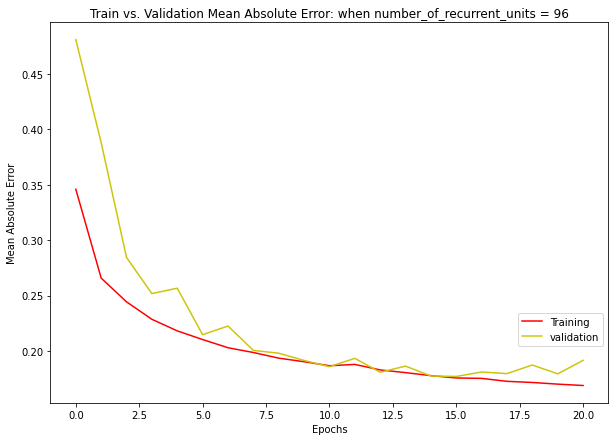

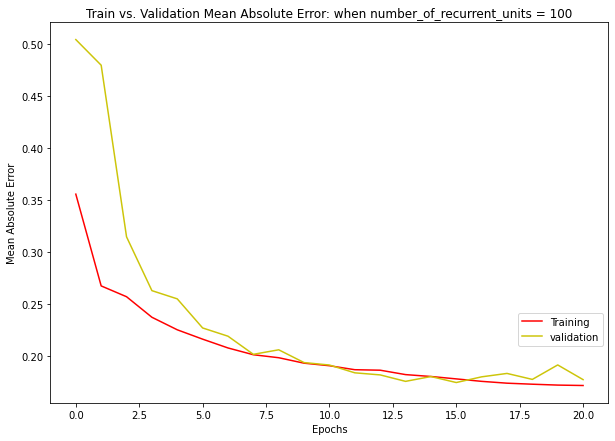

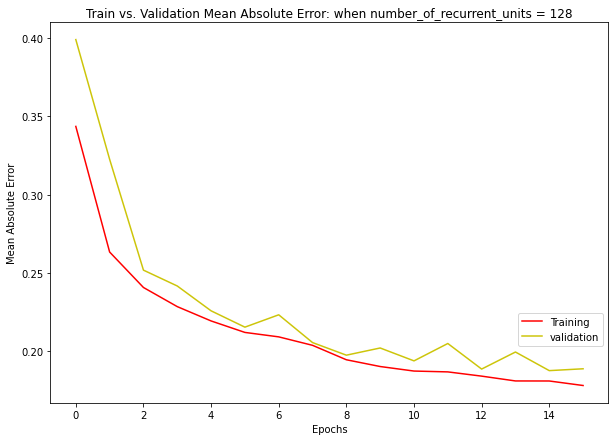

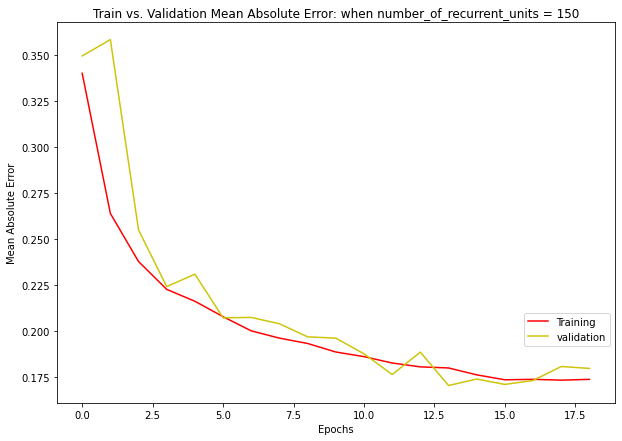

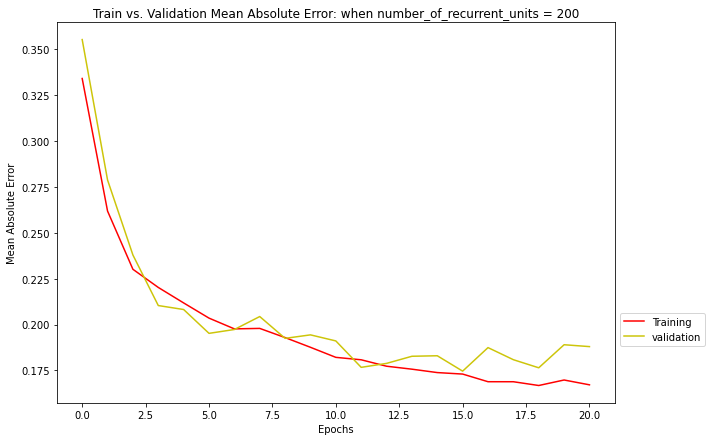

time: 2.48 s (started: 2022-06-30 13:12:31 +00:00)


In [ ]:
# helper function that generates performance plots
generatePlot_mae(history_D_lr_ru, 100, 'number_of_recurrent_units')

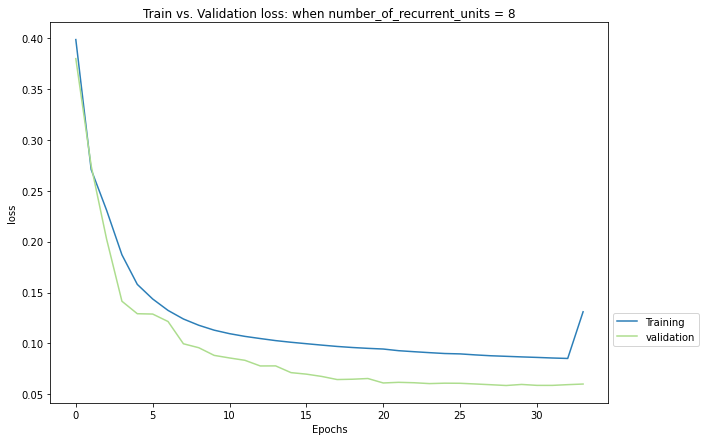

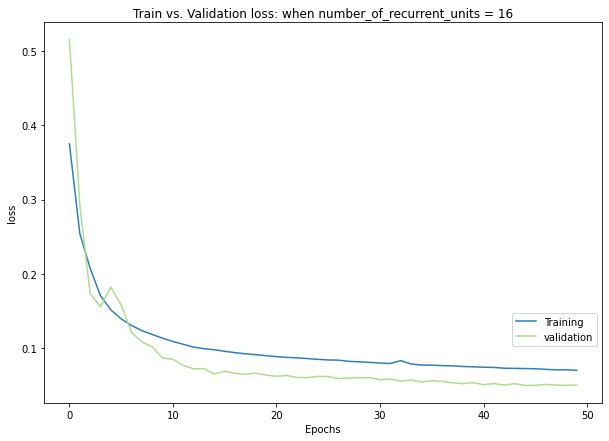

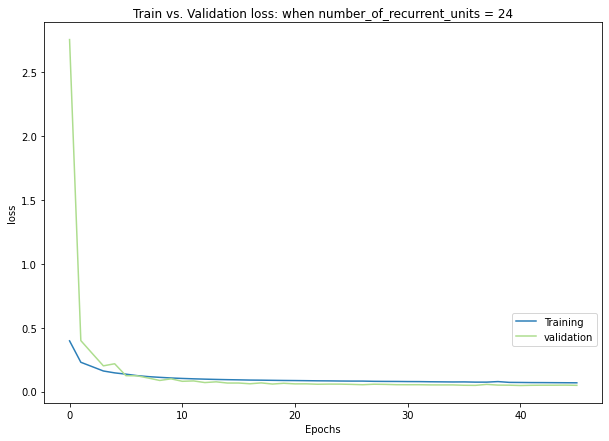

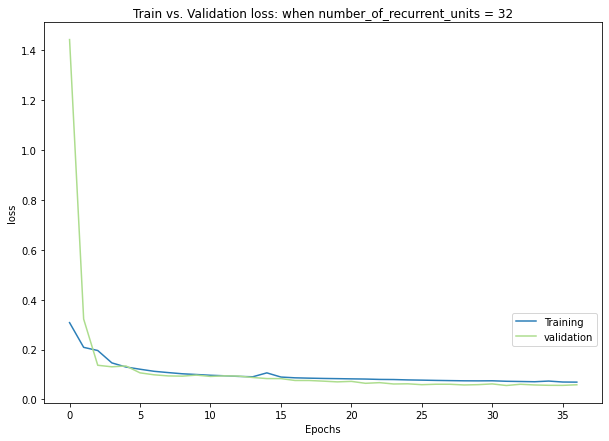

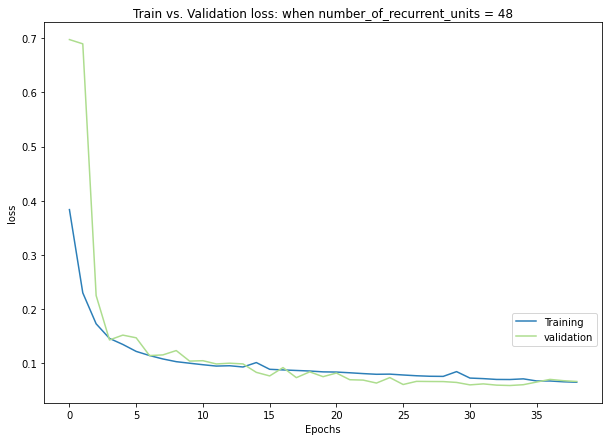

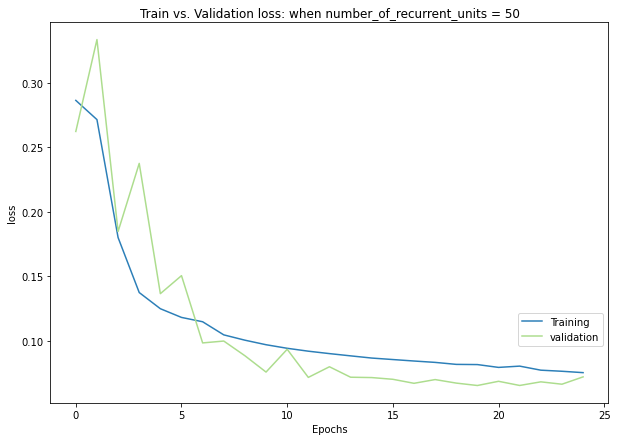

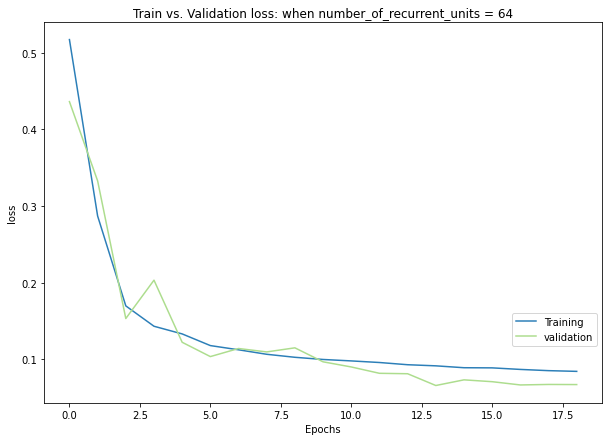

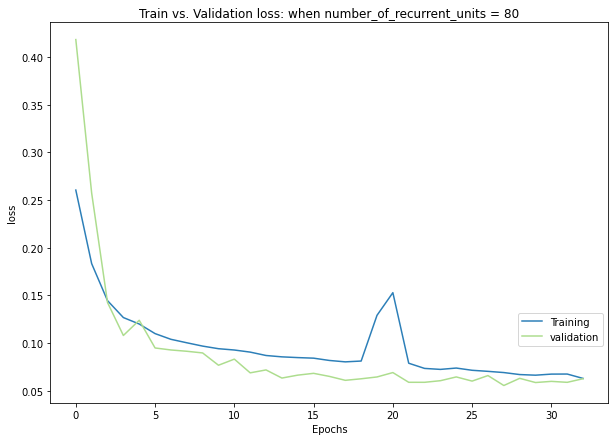

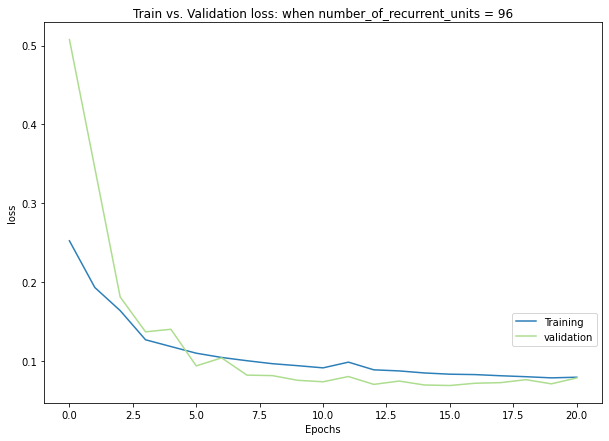

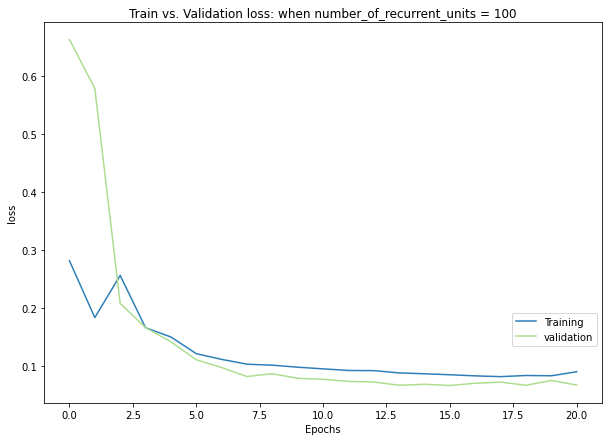

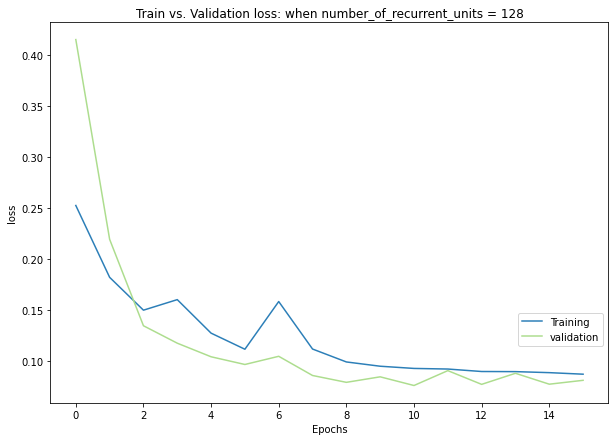

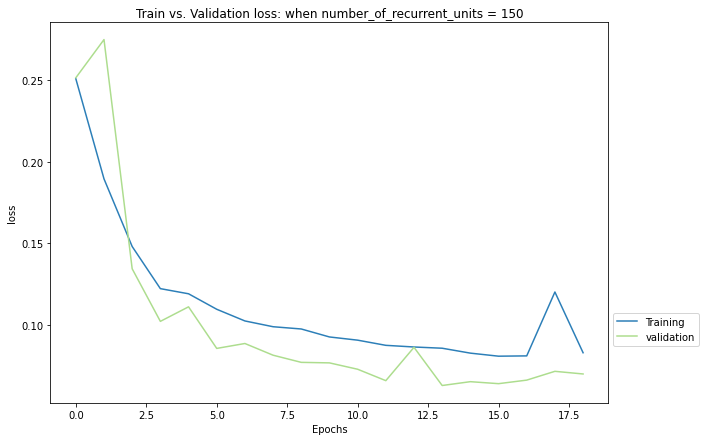

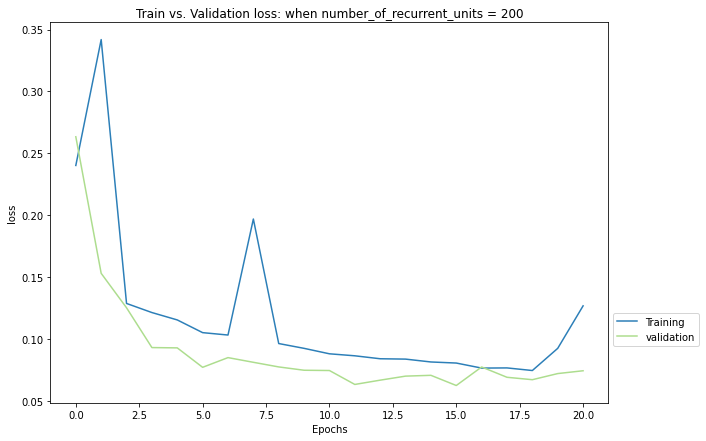

time: 2.43 s (started: 2022-06-30 13:12:33 +00:00)


In [ ]:
# helper function that generates the plots for the different hyper parameters:
generate_loss_Plot(history_D_lr_ru, 100, 'number_of_recurrent_units')

Amongest the different number of recurrent units, 16 is the number with lowest validation loss and the mean absolute error.

Create Different Pandas data frame for analysis.

In [ ]:
train_loss_mae_ru_df, val_loss_mae_ru_df, test_loss_mae_ru_df, recordTime_df = deriveDataFrame(train_performance_lr_ru,val_performance_lr_ru, performance_lr_ru, 'number_of_recurrent_units', recordTime_L)

time: 7.13 ms (started: 2022-06-30 13:12:36 +00:00)


In [ ]:
val_loss_mae_ru_df

,number_of_recurrent_units,val_loss,val_mae
0,8,0.060215,0.173974
1,16,0.050310,0.157269
2,24,0.048823,0.156343
3,32,0.058758,0.167972
4,48,0.065971,0.186441
5,50,0.071918,0.180609
6,64,0.066891,0.179444
7,80,0.062805,0.170822
8,96,0.078020,0.191535
9,100,0.066683,0.177648


time: 6.53 ms (started: 2022-06-30 13:12:36 +00:00)


In [ ]:
test_loss_mae_ru_df

,number_of_recurrent_units,test_loss,test_mae
0,8,0.050732,0.169581
1,16,0.044403,0.153031
2,24,0.044645,0.156620
3,32,0.064339,0.184738
4,48,0.060681,0.185801
5,50,0.081041,0.196749
6,64,0.068067,0.190824
7,80,0.070662,0.190741
8,96,0.084384,0.207984
9,100,0.073783,0.192175


time: 7.76 ms (started: 2022-06-30 13:12:36 +00:00)


### Include hidden layer and tune for the dense number of units used.

In [ ]:
history_D_lr_du = {}
units_L = [8, 16, 24, 32, 48, 50, 64, 80, 100]
recordTime_L = []                             # list of run time execution for each mini batch size
val_performance_lr_du = {}
performance_lr_du = {}
train_performance_lr_du = {}
MAX_EPOCHS = 100
early_stopping = EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min', verbose=1)
for ru in range(len(units_L)):
  print('The number of units in the hidden layer  : %s' %str(units_L[ru]))
  
  bi_directional_lr_du = Sequential()
  # research about input_shape = (n_input, n_features)
  bi_directional_lr_du.add(Bidirectional(LSTM(16, activation='relu', return_sequences=True, input_shape=(5, 9))))
  bi_directional_lr_du.add(Bidirectional(LSTM(16, activation='relu', return_sequences=False)))
  bi_directional_lr_du.add(Dense(units_L[ru]))
  bi_directional_lr_du.add(Dense(1))
  bi_directional_lr_du.add(Reshape([1, -1]))

  # set the learning rate
  opt = tf.optimizers.Adam(learning_rate=0.001)
  bi_directional_lr_du.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])
  # startime
  startTime = time.time()

  history = bi_directional_lr_du.fit(window_5_1_2.train, epochs=MAX_EPOCHS
                                ,batch_size=64
                                ,validation_data=window_5_1_2.val
                                , callbacks=[early_stopping])
  endTime = time.time()

  recordTime_L.append((units_L[ru], endTime - startTime))
  
  # insert the history of the current execution into a dictionary.
  history_D_lr_du[units_L[ru]] = history

  IPython.display.clear_output()
  train_performance_lr_du[str(units_L[ru])] = bi_directional_lr_du.evaluate(window_5_1_2.train)
  val_performance_lr_du[str(units_L[ru])] = bi_directional_lr_du.evaluate(window_5_1_2.val)
  performance_lr_du[str(units_L[ru])] = bi_directional_lr_du.evaluate(window_5_1_2.test, verbose=0)

334/334 [==============================] - 2s 5ms/step - loss: 0.1358 - mean_absolute_error: 0.2620
time: 2h 3min 9s (started: 2022-06-30 13:12:36 +00:00)


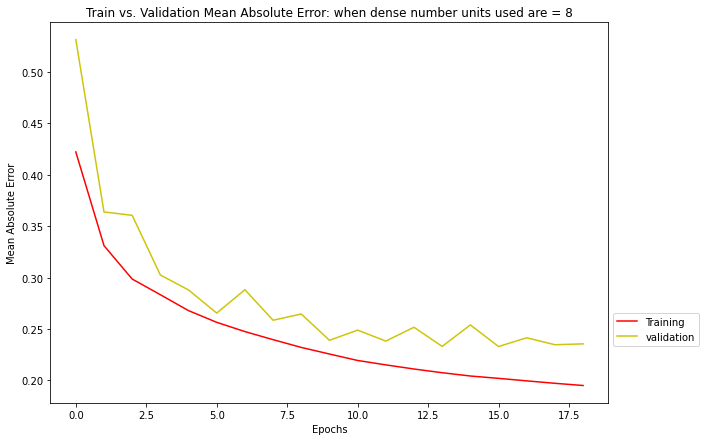

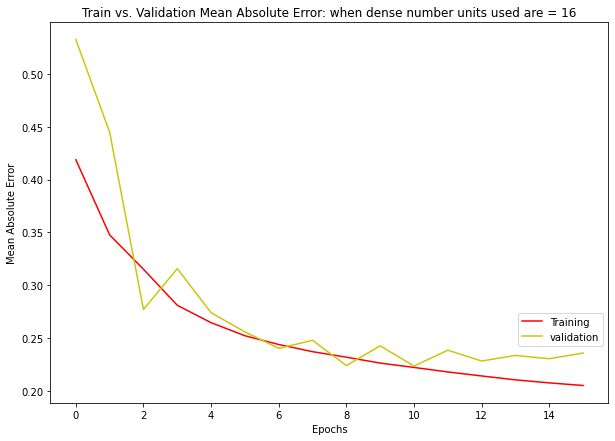

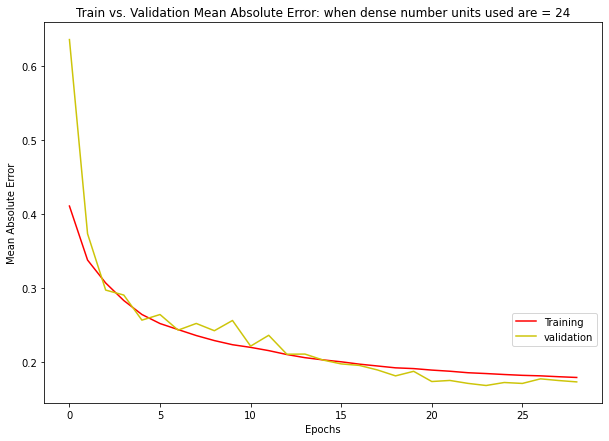

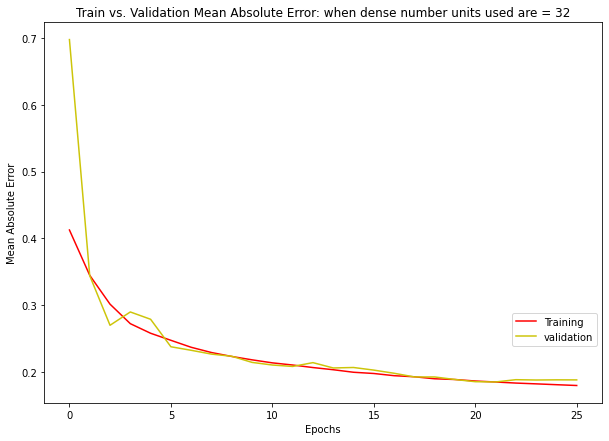

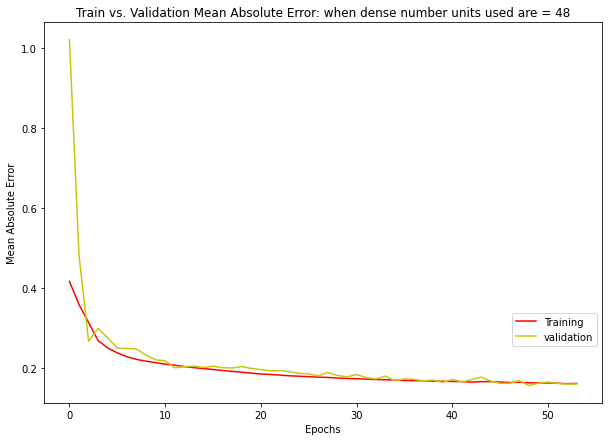

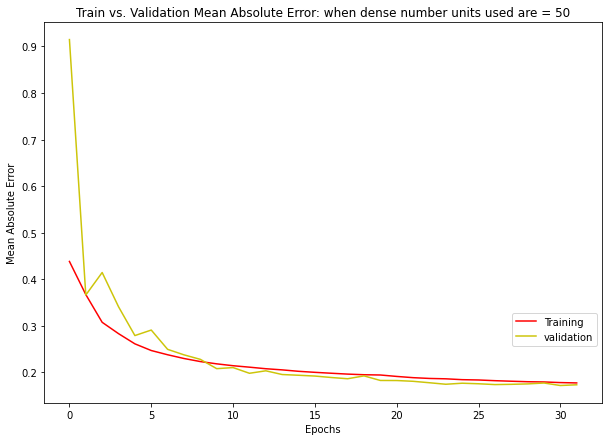

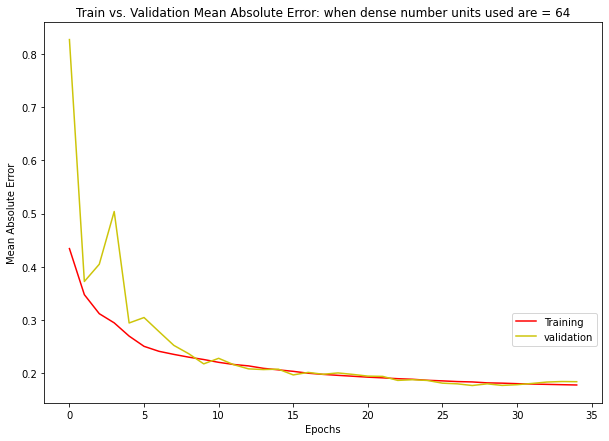

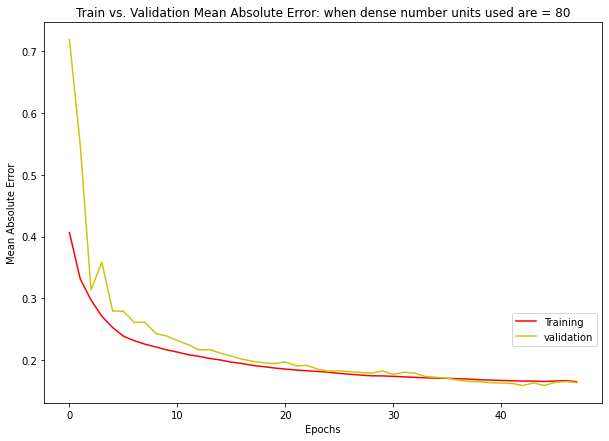

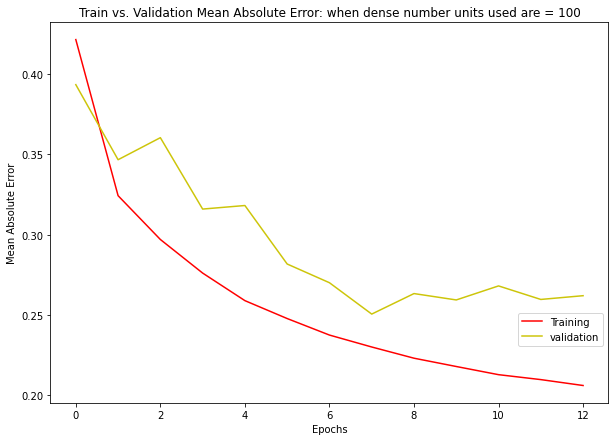

time: 1.9 s (started: 2022-06-30 15:15:45 +00:00)


In [ ]:
# helper function that generates performance plots
generatePlot_mae(history_D_lr_du, 100, 'dense number units used are')

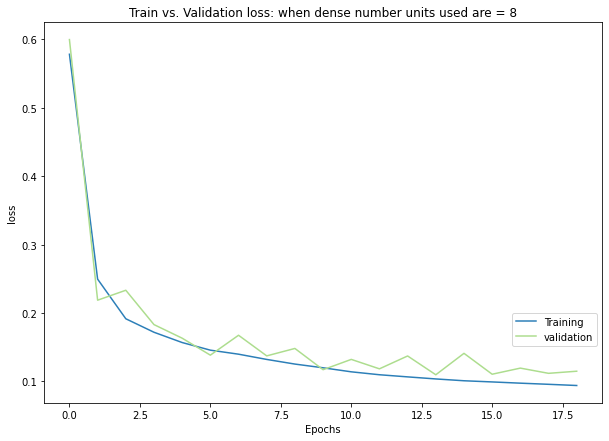

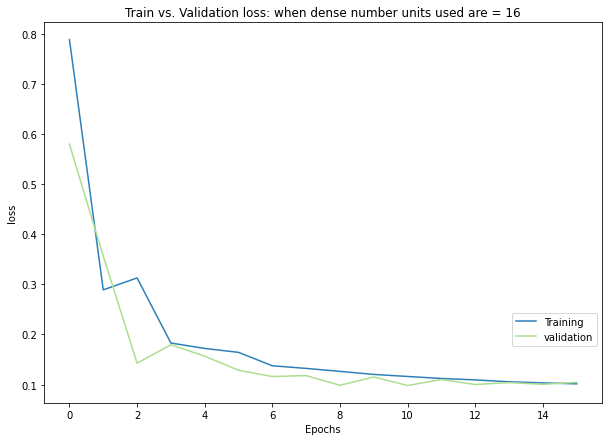

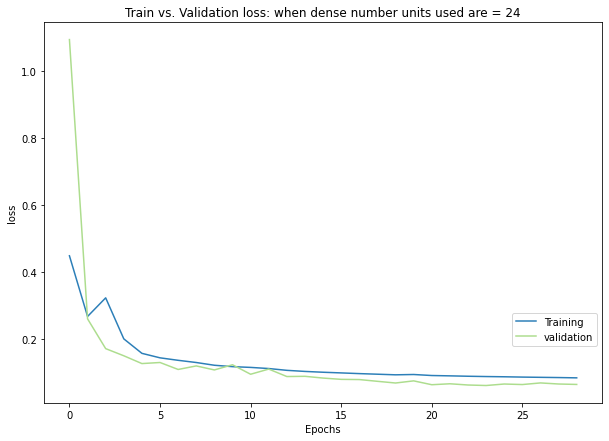

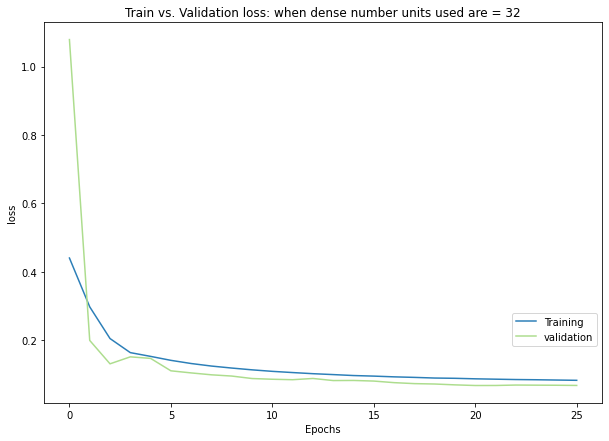

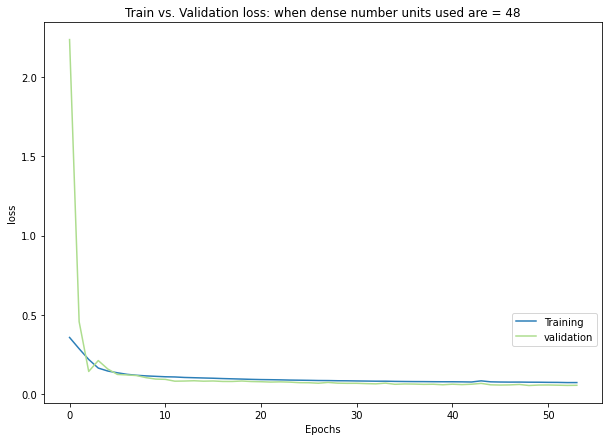

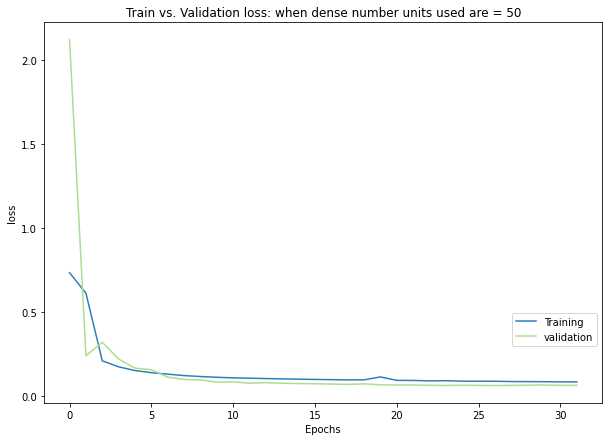

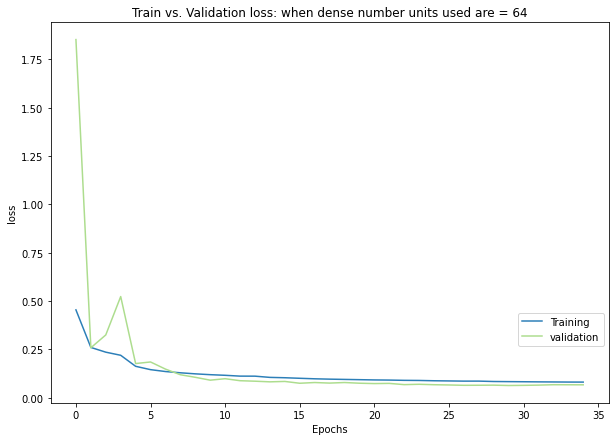

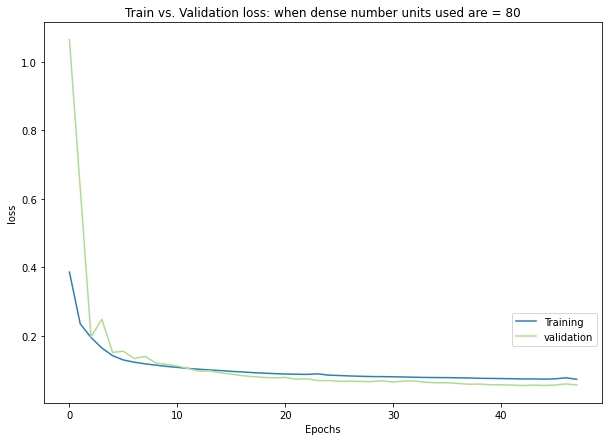

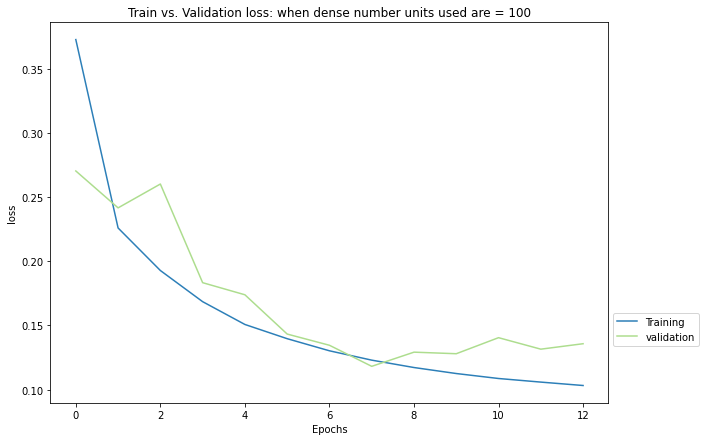

time: 1.77 s (started: 2022-06-30 15:15:47 +00:00)


In [ ]:
# helper function that generates the plots for the different hyper parameters:
generate_loss_Plot(history_D_lr_du, 100, 'dense number units used are')

In [ ]:
# a helper function that derives the data frame for the train_loss_mae, val_loss_mae, test_loss_mae
train_loss_mae_du_df, val_loss_mae_du_df, test_loss_mae_du_df, recordTime_df = deriveDataFrame(train_performance_lr_du,val_performance_lr_du, performance_lr_du, 'number_of_units_used', recordTime_L)

time: 7.61 ms (started: 2022-06-30 15:15:49 +00:00)


In [ ]:
val_loss_mae_du_df

,number_of_units_used,val_loss,val_mae
0,8,0.114920,0.235569
1,16,0.104497,0.235789
2,24,0.064358,0.173861
3,32,0.068041,0.187976
4,48,0.053012,0.161358
5,50,0.061459,0.173550
6,64,0.066655,0.183972
7,80,0.055928,0.163619
8,100,0.135778,0.262017


time: 8.2 ms (started: 2022-06-30 15:15:49 +00:00)


In [ ]:
test_loss_mae_du_df

,number_of_units_used,test_loss,test_mae
0,8,0.141874,0.266544
1,16,0.119604,0.257796
2,24,0.062887,0.181086
3,32,0.068748,0.199037
4,48,0.047448,0.159096
5,50,0.053995,0.173413
6,64,0.066709,0.195182
7,80,0.057781,0.175424
8,100,0.178498,0.313739


time: 6.97 ms (started: 2022-06-30 15:15:49 +00:00)


#### lets build a model with the best determined parameters

##### Building abi-directional model with two layers

In [ ]:
# 128
MAX_EPOCHS = 50
early_stopping = EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min', verbose=1)
bi_directional_ru_du = Sequential()
# research about input_shape = (n_input, n_features)
bi_directional_ru_du.add(Bidirectional(LSTM(16, activation='relu', return_sequences=True)))
bi_directional_ru_du.add(Bidirectional(LSTM(16, activation='relu', return_sequences=True)))
# added this 
#bi_directional_ru_du.add(Bidirectional(LSTM(16, activation='relu', return_sequences=False)))
bi_directional_ru_du.add(Dense(128))
bi_directional_ru_du.add(Dense(1))
#bi_directional_ru_du.add(Reshape([1, -1]))

# set the learning rate
opt = tf.optimizers.Adam(learning_rate=0.001)
bi_directional_ru_du.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])

# fit the model with the training data
history_ru_bu = bi_directional_ru_du.fit(window_5_1_2.train, epochs=MAX_EPOCHS
                                ,batch_size=32
                                ,validation_data=window_5_1_2.val
                                , callbacks=[early_stopping])


IPython.display.clear_output()
#train_performance_lr_du[str(units_L[ru])] = bi_directional_lr_du.evaluate(window_5_1_2.train)
val_performance['bi_directional_ru_du'] = bi_directional_ru_du.evaluate(window_5_1_2.val)
performance['bi_directional_ru_du'] = bi_directional_ru_du.evaluate(window_5_1_2.test, verbose=0)

334/334 [==============================] - 2s 6ms/step - loss: 0.0518 - mean_absolute_error: 0.1549
time: 22min 56s (started: 2022-06-30 15:15:49 +00:00)


In [ ]:
print('Input shape:', window_5_1_2.example[0].shape)
print('Output shape:', bi_directional_ru_du(window_5_1_2.example[0]).shape)

Input shape: (32, 5, 9)
Output shape: (32, 5, 1)
time: 51.5 ms (started: 2022-06-30 15:38:46 +00:00)


plot the predictions of the model

In [ ]:
#window_5_1_2.plot(bi_directional_ru_du)

time: 766 µs (started: 2022-06-30 15:38:46 +00:00)


##### Save model to the file system

In [ ]:
#bi_directional_ru_du.save("bi_directional_ru_du.model")

time: 797 µs (started: 2022-06-30 15:38:46 +00:00)


load the saved model:

In [ ]:
# bi_directional_ru_du_res = models.load_model('bi_directional_ru_du.model')

time: 693 µs (started: 2022-06-30 15:38:46 +00:00)


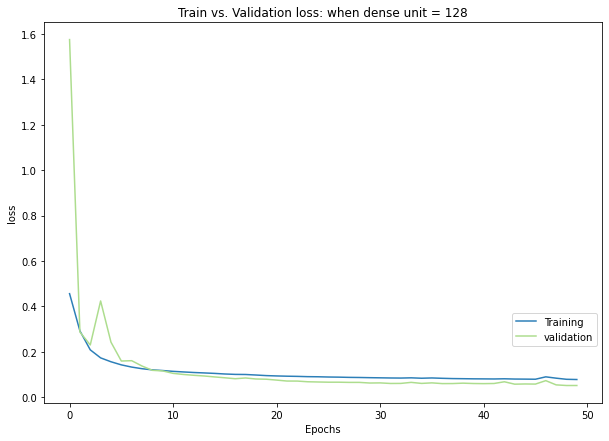

time: 202 ms (started: 2022-06-30 15:38:46 +00:00)


In [ ]:
#def generate_loss_Plot(history_D, EPOCHS=100, titleStr='batch size'):
"""
  Function takes a dictionary of History callbacks and 
  plots line charts for the different hyper parameters
"""
  #print('Training and validation loss line charts for the different mini batch sizes')
  # loop through the history dictionary to access the different items
#for key, value in history_D.items():
    # set the figure
plt.figure(figsize=(10, 7))
line_loss = plt.plot(range(0,len(history_ru_bu.history['loss'])), history_ru_bu.history['loss'], '#2c7fb8')
line_val = plt.plot(range(0,len(history_ru_bu.history['val_loss'])), history_ru_bu.history['val_loss'], '#addd8e')

plt.title('Train vs. Validation loss: when dense unit = 128' )
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'validation'], bbox_to_anchor=(1, 0.25))
print('\n')

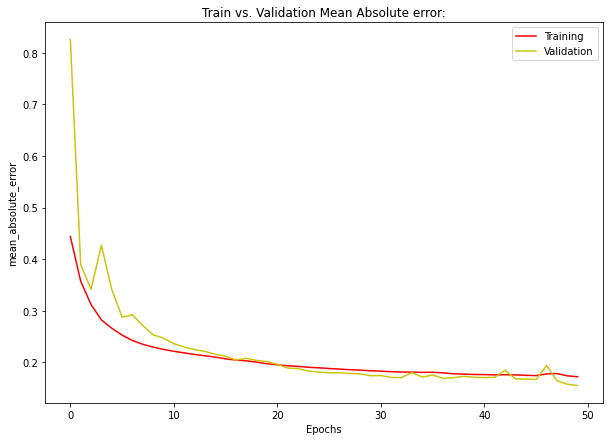

time: 196 ms (started: 2022-06-30 15:38:46 +00:00)


In [ ]:
plt.figure(figsize=(10, 7))
line_train = plt.plot(range(0,len(history_ru_bu.history['mean_absolute_error'])), history_ru_bu.history['mean_absolute_error'], 'r')
line_val = plt.plot(range(0,len(history_ru_bu.history['val_mean_absolute_error'])), history_ru_bu.history['val_mean_absolute_error'], '#cdc50a')
plt.title('Train vs. Validation Mean Absolute error:')
plt.ylabel('mean_absolute_error')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])
print('\n')

We observe that when the model is starting to fit the data, the validation loss and mae is unstable.

##### Derive the predictions

In [ ]:
# a helper function that retruns the predictions after passing the testing 
# data set of the WindowGeneratotr object as input parameter 
# to the predict function of the model, basic_lstm_model
prediction_res_ru_du = derivePredictions(bi_directional_ru_du)

The shape of the predictions : (4994, 5, 1)
time: 1.38 s (started: 2022-06-30 15:38:46 +00:00)


##### Denormalize the predictions

In [ ]:
# using a helper function to denormalize the predictions and return data frame
predicted_traffic_volume_df_ru_du = denormalizeDataFile(prediction_res_ru_du)

time: 1.3 s (started: 2022-06-30 15:38:47 +00:00)


In [ ]:
# the top 5 records 
predicted_traffic_volume_df_ru_du.tail()

,prediction
id,
4990,3187.038586
4991,2873.684282
4992,2852.335669
4993,2531.580913
4994,1598.322191


time: 7.37 ms (started: 2022-06-30 15:38:49 +00:00)


##### Write the prediction to a file

In [ ]:
# a helper function that recieves a data frame as an argument 
# and writes the contents of the data frame to a csv file
writePredictionsToCsv(predicted_traffic_volume_df_ru_du)

time: 18.2 ms (started: 2022-06-30 15:38:49 +00:00)


#### Building the bidirectional model with 3 layers, batch size of 4 and learning rate 0.001

In [ ]:
#batch_size = 4
MAX_EPOCHS = 50
early_stopping = EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min', verbose=1)
bi_directional_bs4 = Sequential()
# research about input_shape = (n_input, n_features)
bi_directional_bs4.add(Bidirectional(LSTM(16, activation='relu', return_sequences=True)))
bi_directional_bs4.add(Bidirectional(LSTM(16, activation='relu', return_sequences=True)))
# added this 
bi_directional_bs4.add(Bidirectional(LSTM(16, activation='relu', return_sequences=False)))
bi_directional_bs4.add(Dense(128))
bi_directional_bs4.add(Dense(1))
bi_directional_bs4.add(Reshape([1, -1]))

# set the learning rate
opt = tf.optimizers.Adam(learning_rate=0.001)
bi_directional_bs4.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])

# fit the model with the training data
history = bi_directional_bs4.fit(window_5_1_2.train, epochs=MAX_EPOCHS
                                ,batch_size=4
                                ,validation_data=window_5_1_2.val
                                , callbacks=[early_stopping])


IPython.display.clear_output()
#train_performance_lr_du[str(units_L[ru])] = bi_directional_lr_du.evaluate(window_5_1_2.train)
val_performance['bi_directional_bs4'] = bi_directional_bs4.evaluate(window_5_1_2.val)
performance['bi_directional_bs4'] = bi_directional_bs4.evaluate(window_5_1_2.test, verbose=0)

334/334 [==============================] - 2s 7ms/step - loss: 0.0679 - mean_absolute_error: 0.1832
time: 27min 35s (started: 2022-06-30 15:38:49 +00:00)


In [ ]:
print('Input shape:', window_5_1_2.example[0].shape)
print('Output shape:', bi_directional_bs4(window_5_1_2.example[0]).shape)

Input shape: (32, 5, 9)
Output shape: (32, 1, 1)
time: 78.8 ms (started: 2022-06-30 16:06:25 +00:00)


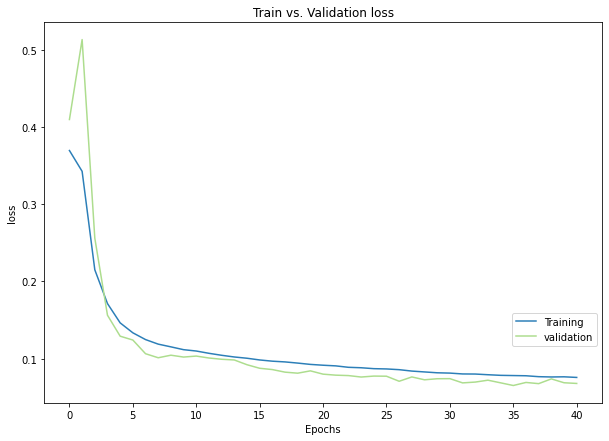

time: 212 ms (started: 2022-06-30 16:06:25 +00:00)


In [ ]:
#def generate_loss_Plot(history_D, EPOCHS=100, titleStr='batch size'):
"""
  Function takes a dictionary of History callbacks and 
  plots line charts for the different hyper parameters
"""
  #print('Training and validation loss line charts for the different mini batch sizes')
  # loop through the history dictionary to access the different items
#for key, value in history_D.items():
    # set the figure
plt.figure(figsize=(10, 7))
line_loss = plt.plot(range(0,len(history.history['loss'])), history.history['loss'], '#2c7fb8')
line_val = plt.plot(range(0,len(history.history['val_loss'])), history.history['val_loss'], '#addd8e')

plt.title('Train vs. Validation loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'validation'], bbox_to_anchor=(1, 0.25))
print('\n')

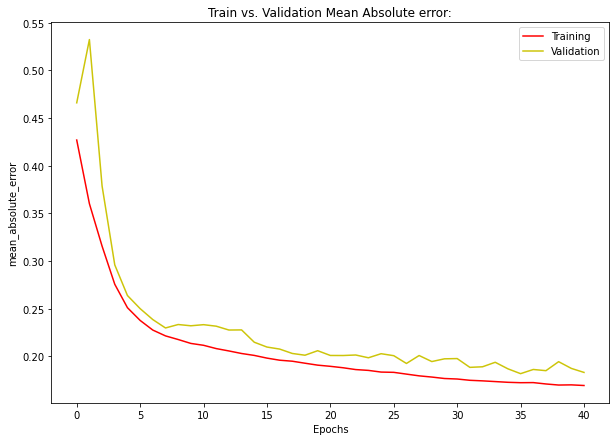

time: 208 ms (started: 2022-06-30 16:06:25 +00:00)


In [ ]:
plt.figure(figsize=(10, 7))
line_train = plt.plot(range(0,len(history.history['mean_absolute_error'])), history.history['mean_absolute_error'], 'r')
line_val = plt.plot(range(0,len(history.history['val_mean_absolute_error'])), history.history['val_mean_absolute_error'], '#cdc50a')
plt.title('Train vs. Validation Mean Absolute error:')
plt.ylabel('mean_absolute_error')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])
print('\n')

Validation mean absolute error is unstable because the model has alot of parameters

In [ ]:
bi_directional_bs4.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_94 (Bidirecti  (None, 5, 32)            3328      
 onal)                                                           
                                                                 
 bidirectional_95 (Bidirecti  (None, 5, 32)            6272      
 onal)                                                           
                                                                 
 bidirectional_96 (Bidirecti  (None, 32)               6272      
 onal)                                                           
                                                                 
 dense_67 (Dense)            (None, 128)               4224      
                                                                 
 dense_68 (Dense)            (None, 1)                 129       
                                                     

###### derive predictions

In [ ]:
# a helper function that retruns the predictions after passing the testing 
# data set of the WindowGeneratotr object as input parameter 
# to the predict function of the model, basic_lstm_model
prediction_res_bs4 = derivePredictions(bi_directional_bs4)

The shape of the predictions : (4994, 1, 1)
time: 1.77 s (started: 2022-06-30 16:06:25 +00:00)


In [ ]:
# using a helper function to denormalize the predictions and return data frame
predicted_traffic_volume_df_bs4 = denormalizeDataFile(prediction_res_bs4)

time: 1.38 s (started: 2022-06-30 16:06:27 +00:00)


In [ ]:
predicted_traffic_volume_df_bs4

,prediction
id,
1,3090.756256
2,5778.908894
3,6432.032862
4,5757.375865
5,4395.369555
...,...
4990,3472.557131
4991,3025.227647
4992,2746.137730


time: 8.44 ms (started: 2022-06-30 16:06:28 +00:00)


###### Write the predictions to a file

In [ ]:
writePredictionsToCsv(predicted_traffic_volume_df_bs4)

time: 18.2 ms (started: 2022-06-30 16:06:28 +00:00)


## Stacked LSTM

In [ ]:
# next run
MAX_EPOCHS = 150
early_stopping = EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min', verbose=1)
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(128, return_sequences=True, activation='relu'))
stacked_lstm.add(Dropout(0.4))
stacked_lstm.add(LSTM(50, activation='relu'))
stacked_lstm.add(Dropout(0.4))
stacked_lstm.add(Dense(32))
stacked_lstm.add(Dense(1))
#bi_directional_one_layer.add(Reshape([1, -1]))


# set the learning rate
opt = tf.optimizers.Adam(learning_rate=0.0001)
stacked_lstm.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])

# fit the model with the training data
history_stacked_lstm = stacked_lstm.fit(window_5_1_2.train, epochs=MAX_EPOCHS
                                ,batch_size=4
                                ,validation_data=window_5_1_2.val
                                , callbacks=[early_stopping])


IPython.display.clear_output()
val_performance['stacked_lstm_dropout'] = stacked_lstm.evaluate(window_5_1_2.val)
performance['stacked_lstm_dropout'] = stacked_lstm.evaluate(window_5_1_2.test, verbose=0)


334/334 [==============================] - 1s 4ms/step - loss: 0.0573 - mean_absolute_error: 0.1720
time: 12min 40s (started: 2022-06-30 16:06:28 +00:00)


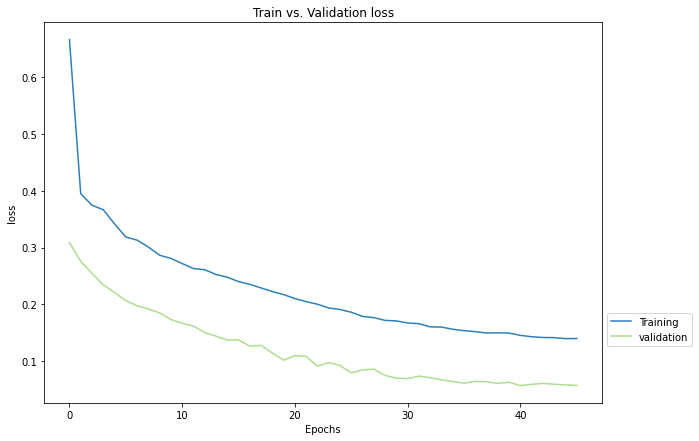

time: 194 ms (started: 2022-06-30 16:19:09 +00:00)


In [ ]:
#def generate_loss_Plot(history_D, EPOCHS=100, titleStr='batch size'):
"""
  Function takes a dictionary of History callbacks and 
  plots line charts for the different hyper parameters
"""
  #print('Training and validation loss line charts for the different mini batch sizes')
  # loop through the history dictionary to access the different items
#for key, value in history_D.items():
    # set the figure
plt.figure(figsize=(10, 7))
line_loss = plt.plot(range(0,len(history_stacked_lstm.history['loss'])), history_stacked_lstm.history['loss'], '#2c7fb8')
line_val = plt.plot(range(0,len(history_stacked_lstm.history['val_loss'])), history_stacked_lstm.history['val_loss'], '#addd8e')

plt.title('Train vs. Validation loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'validation'], bbox_to_anchor=(1, 0.25))
print('\n')

There is a lot of overfitting on the training data.

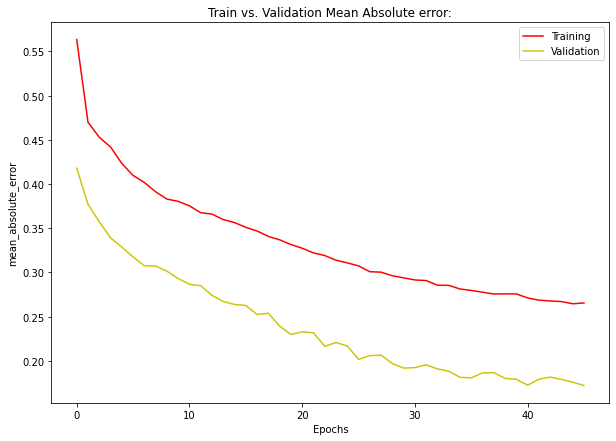

time: 197 ms (started: 2022-06-30 16:19:10 +00:00)


In [ ]:
plt.figure(figsize=(10, 7))
line_train = plt.plot(range(0,len(history_stacked_lstm.history['mean_absolute_error'])), history_stacked_lstm.history['mean_absolute_error'], 'r')
line_val = plt.plot(range(0,len(history_stacked_lstm.history['val_mean_absolute_error'])), history_stacked_lstm.history['val_mean_absolute_error'], '#cdc50a')
plt.title('Train vs. Validation Mean Absolute error:')
plt.ylabel('mean_absolute_error')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])
print('\n')

##### Derive the predictions

In [ ]:
# a helper function that retruns the predictions after passing the testing 
# data set of the WindowGeneratotr object as input parameter 
# to the predict function of the model, basic_lstm_model
prediction_res_stacked_lstm = derivePredictions(stacked_lstm)

The shape of the predictions : (4994, 1)
time: 856 ms (started: 2022-06-30 16:19:10 +00:00)


In [ ]:
# using a helper function to denormalize the predictions and return data frame
predicted_traffic_volume_df_stacked_lstm = denormalizeDataFile(prediction_res_stacked_lstm)

time: 1.27 s (started: 2022-06-30 16:19:11 +00:00)


In [ ]:
# top 5 records of the data frame.
predicted_traffic_volume_df_stacked_lstm.head()

,prediction
id,
1,2526.674156
2,5404.366091
3,6059.002858
4,5277.363479
5,4794.023716


time: 5.83 ms (started: 2022-06-30 16:19:12 +00:00)


##### Write the predictions to a file

In [ ]:
writePredictionsToCsv(predicted_traffic_volume_df_stacked_lstm)

time: 18.9 ms (started: 2022-06-30 16:19:12 +00:00)


#### Adding Recurrent dropout

In [ ]:
# using the batch size of 32
MAX_EPOCHS = 100
early_stopping = EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min', verbose=1)
stacked_lstm_dropout = Sequential()
stacked_lstm_dropout.add(LSTM(128, return_sequences=True, activation='relu'))
stacked_lstm_dropout.add(Dropout(0.4))
stacked_lstm_dropout.add(LSTM(50, activation='relu'))
stacked_lstm_dropout.add(Dropout(0.4))
stacked_lstm_dropout.add(Dense(32))
stacked_lstm_dropout.add(Dense(1))
#bi_directional_one_layer.add(Reshape([1, -1]))


# set the learning rate
opt = tf.optimizers.Adam(learning_rate=0.001)
stacked_lstm_dropout.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])

# fit the model with the training data
history_stacked_lstm_dropout = stacked_lstm_dropout.fit(window_5_1_2.train, epochs=MAX_EPOCHS
                                ,batch_size=32
                                ,validation_data=window_5_1_2.val
                                , callbacks=[early_stopping])


IPython.display.clear_output()
val_performance['stacked_lstm_dropout_3'] = stacked_lstm_dropout.evaluate(window_5_1_2.val)
performance['stacked_lstm_dropout_3'] = stacked_lstm_dropout.evaluate(window_5_1_2.test, verbose=0)


334/334 [==============================] - 1s 4ms/step - loss: 0.0557 - mean_absolute_error: 0.1732
time: 10min 42s (started: 2022-06-30 16:19:12 +00:00)


##### Derive predictions

In [ ]:
# a helper function that retruns the predictions after passing the testing 
# data set of the WindowGeneratotr object as input parameter 
# to the predict function of the model, basic_lstm_model
prediction_res_stacked_lstm_dropout = derivePredictions(stacked_lstm_dropout)

The shape of the predictions : (4994, 1)
time: 881 ms (started: 2022-06-30 16:29:55 +00:00)


In [ ]:
# using a helper function to denormalize the predictions and return data frame
predicted_traffic_volume_df_stacked_lstm_dropout = denormalizeDataFile(prediction_res_stacked_lstm_dropout)

time: 1.26 s (started: 2022-06-30 16:29:56 +00:00)


In [ ]:
# view the top 5 records of the  predictions
predicted_traffic_volume_df_stacked_lstm_dropout.head()

,prediction
id,
1,2992.913874
2,5688.879166
3,6324.981468
4,5218.768871
5,4173.747057


time: 6.74 ms (started: 2022-06-30 16:29:57 +00:00)


##### Write the predictions to a file

In [ ]:
writePredictionsToCsv(predicted_traffic_volume_df_stacked_lstm_dropout)

time: 18.4 ms (started: 2022-06-30 16:29:57 +00:00)


##### Recurrent drop out added
 with batch size of 50

In [181]:
# using the batch size of 60
MAX_EPOCHS = 100
early_stopping = EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min', verbose=1)
stacked_lstm_dropout = Sequential()
stacked_lstm_dropout.add(LSTM(128, return_sequences=True, activation='relu'))
stacked_lstm_dropout.add(Dropout(0.4))
stacked_lstm_dropout.add(LSTM(50, activation='relu'))
stacked_lstm_dropout.add(Dropout(0.4))
stacked_lstm_dropout.add(Dense(32))
stacked_lstm_dropout.add(Dense(1))
#bi_directional_one_layer.add(Reshape([1, -1]))


# set the learning rate
opt = tf.optimizers.Adam(learning_rate=0.0001)
stacked_lstm_dropout.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])

# fit the model with the training data
history_stacked_lstm_dropout = stacked_lstm_dropout.fit(window_5_1_2.train, epochs=MAX_EPOCHS
                                ,batch_size=50
                                ,validation_data=window_5_1_2.val
                                , callbacks=[early_stopping])


IPython.display.clear_output()
val_performance['stacked_lstm_dropout_3'] = stacked_lstm_dropout.evaluate(window_5_1_2.val)
performance['stacked_lstm_dropout_3'] = stacked_lstm_dropout.evaluate(window_5_1_2.test, verbose=0)


334/334 [==============================] - 1s 4ms/step - loss: 0.0472 - mean_absolute_error: 0.1520
time: 20min 49s (started: 2022-06-30 16:29:57 +00:00)


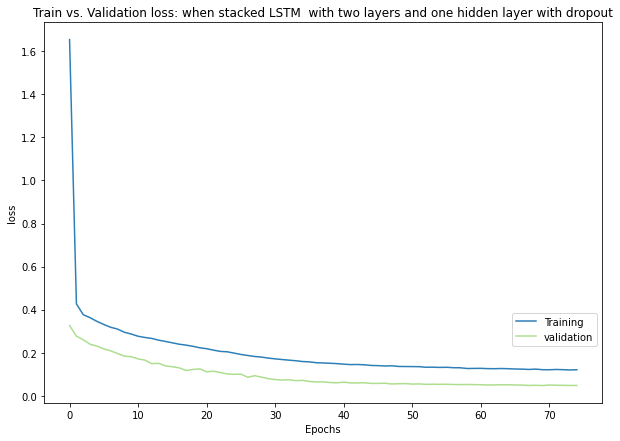

time: 191 ms (started: 2022-06-30 16:50:46 +00:00)


In [182]:
plt.figure(figsize=(10, 7))
line_loss = plt.plot(range(0,len(history_stacked_lstm_dropout.history['loss'])), history_stacked_lstm_dropout.history['loss'], '#2c7fb8')
line_val = plt.plot(range(0,len(history_stacked_lstm_dropout.history['val_loss'])), history_stacked_lstm_dropout.history['val_loss'], '#addd8e')

plt.title('Train vs. Validation loss: when stacked LSTM  with two layers and one hidden layer with dropout')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'validation'], bbox_to_anchor=(1, 0.25))
plt.show()

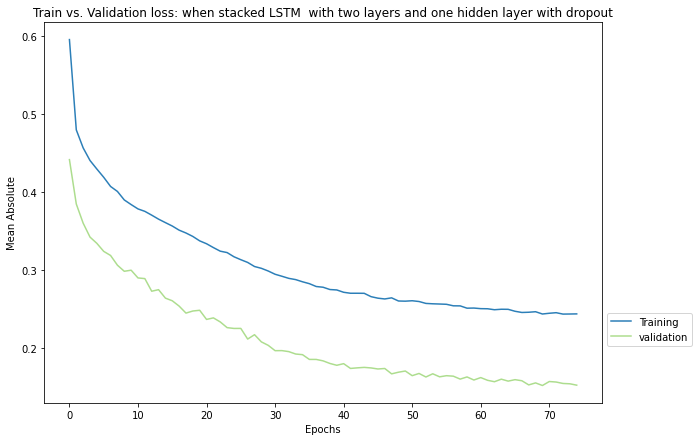

time: 183 ms (started: 2022-06-30 16:50:46 +00:00)


In [183]:
plt.figure(figsize=(10, 7))
line_loss = plt.plot(range(0,len(history_stacked_lstm_dropout.history['mean_absolute_error'])), history_stacked_lstm_dropout.history['mean_absolute_error'], '#2c7fb8')
line_val = plt.plot(range(0,len(history_stacked_lstm_dropout.history['val_mean_absolute_error'])), history_stacked_lstm_dropout.history['val_mean_absolute_error'], '#addd8e')
plt.title('Train vs. Validation loss: when stacked LSTM  with two layers and one hidden layer with dropout')
plt.ylabel('Mean Absolute')
plt.xlabel('Epochs')
plt.legend(['Training', 'validation'], bbox_to_anchor=(1, 0.25))
plt.show()

We observe that even though validation loss and mae are good, the model is overfitting on the training data. 

##### derive the predictions

In [184]:
# a helper function that retruns the predictions after passing the testing 
# data set of the WindowGeneratotr object as input parameter 
# to the predict function of the model, basic_lstm_model
prediction_res_lstm_stacked_lstm_dropout = derivePredictions(stacked_lstm_dropout)

The shape of the predictions : (4994, 1)
time: 846 ms (started: 2022-06-30 16:50:46 +00:00)


In [185]:
# using a helper function to denormalize the predictions and return data frame
predicted_traffic_volume_df_lstm_stacked_lstm_dropout = denormalizeDataFile(prediction_res_lstm_stacked_lstm_dropout)

time: 2.87 s (started: 2022-06-30 16:50:47 +00:00)


In [186]:
# top 5 records of the predictions
predicted_traffic_volume_df_lstm_stacked_lstm_dropout.head()

,prediction
id,
1,2836.630322
2,5359.788655
3,5994.842741
4,5342.161538
5,4558.074739


time: 6.27 ms (started: 2022-06-30 16:50:50 +00:00)


##### Write the predictions to a file

In [187]:
# a helper function that recieves a data frame as an argument 
# and writes the contents of the data frame to a csv file
writePredictionsToCsv(predicted_traffic_volume_df_lstm_stacked_lstm_dropout)

time: 20.6 ms (started: 2022-06-30 16:50:50 +00:00)


let's look at the performance of the LSTM model comparing it to other models. 

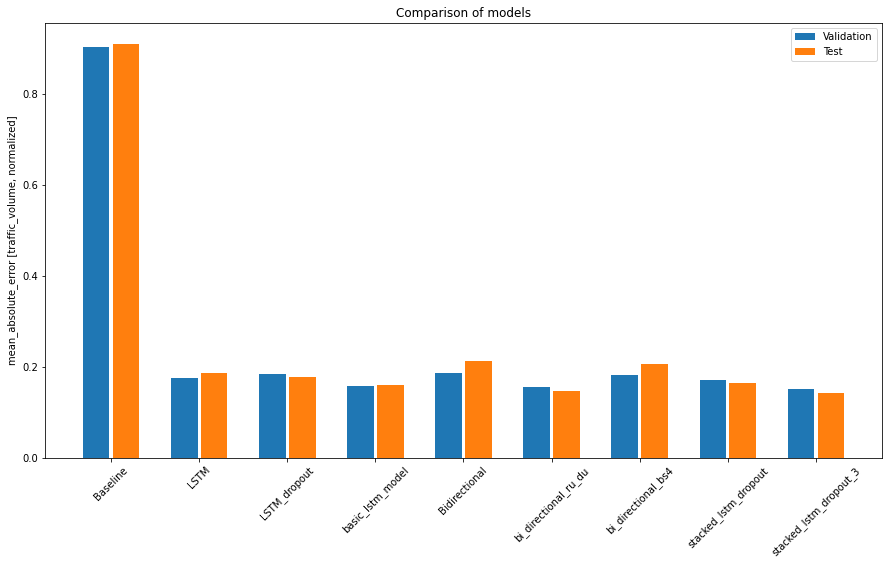

time: 254 ms (started: 2022-06-30 16:50:50 +00:00)


In [188]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]
plt.figure(figsize=(15, 8))
plt.ylabel('mean_absolute_error [traffic_volume, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.title('Comparison of models')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

The Baseline model performs better than any other models

## Combining CNN recurrent neural network

#### 1 Covnet + RNN

In [189]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
convnet_bi_directional = Sequential()
convnet_bi_directional.add(Conv1D(32, 3, activation='relu'))
convnet_bi_directional.add(MaxPooling1D(5))
convnet_bi_directional.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
convnet_bi_directional.add(Dense(1))


time: 23.1 ms (started: 2022-06-30 16:50:51 +00:00)
